# КУРСОВОЙ ПРОЕКТ 
### ПО КУРСУ "Библиотеки Python для Data Science. Продолжение"
Ваша задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).

The evaluation metric for this competition is F1-Score.

F1=2p⋅r/p+r  where  p=tp/tp+fp,  r=tp/tp+fn
 
The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other. (Метрика F1 весит отзыв и точность в равной степени, а хороший алгоритм поиска обеспечит максимальную точность и отзыв одновременно. Таким образом, умеренно хорошая производительность на обоих будет предпочтительнее чрезвычайно хорошей производительности на одном и низкой производительности на другом.)

File descriptions
train.csv - the training set
test.csv - the test set
sampleSubmission.csv - a sample submission file in the correct format


Data fields
* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### СОДЕРЖАНИЕ
* [Загрузка библиотек](#install)
* [Рабочее поле](#biblio)
* [Загрузка датасета](#dt_set)
* [Подготовка данных](#transform)
* [ЭКСПЕРИМЕНТЫ с моделями](#model)
* [Финальный результат](#rezult)
* [Сохранение модели](#savemodel)

### <center>Загрузка библиотек<a class="anchor" id="install"></a><center>

conda update -n base -c defaults conda

conda install -c conda-forge catboost

conda install -c conda-forge lightgbm

pip install imblearn

### <center>Рабочее поле<a class="anchor" id="biblio"></a><center>

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('fivethirtyeight')
%matplotlib inline

# 2. Разделение датасета и генерации
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.svm import SVC

# 4. Метрики качества

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Пути к директориям и файлам
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [4]:
# ГРАФИКИ
def df_num_features_hist(dfx):
    df_num_features = dfx.select_dtypes(include=['float64', 'float32', 'float16','int64'])
    df_num_features.hist(figsize=(16,16), bins=20, grid=False);

# как переменные коррелируют с ценой продажи
def saleprice_corr_heat_map(dfh):
    fig, ax = plt.subplots(figsize=(10,8))
    saleprice_corr = dfh.corr()[['Credit Default']].sort_values(
      by='Credit Default', ascending=False)
    sns.heatmap(saleprice_corr, annot=True, ax=ax) 

### <center>Загрузка датасета<a class="anchor" id="dt_set"></a><center>

In [5]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_test = pd.read_csv(TEST_DATASET_PATH, sep=',')
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df.shape

(7500, 17)

In [7]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [8]:
#что из себя представляют данные
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [11]:
target_name = 'Credit Default'
BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term','Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score']

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [13]:
df.isna()
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [14]:
# определяем концентрацию пропусков в каждом столбце
df.isnull().mean() * 100

Home Ownership                   0.000000
Annual Income                   20.760000
Years in current job             4.946667
Tax Liens                        0.000000
Number of Open Accounts          0.000000
Years of Credit History          0.000000
Maximum Open Credit              0.000000
Number of Credit Problems        0.000000
Months since last delinquent    54.413333
Bankruptcies                     0.186667
Purpose                          0.000000
Term                             0.000000
Current Loan Amount              0.000000
Current Credit Balance           0.000000
Monthly Debt                     0.000000
Credit Score                    20.760000
Credit Default                   0.000000
dtype: float64

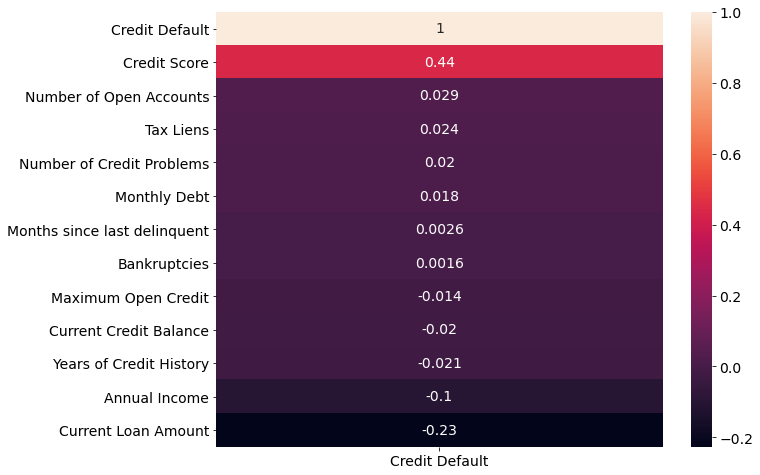

In [15]:
saleprice_corr_heat_map(df)

### <center>Подготовка данных<a class="anchor" id="transform"></a><center>

In [16]:
# избавление от  NAN
def passes (dtset, column_name, replacement): # датасет, столбец, на что заменить NAN
    name_new_columns_nan =column_name + ' NAN'
    dtset[name_new_columns_nan] = 0
    dtset.loc[df[column_name].isna(), name_new_columns_nan] = 1
    dtset[column_name] = dtset[column_name].fillna(replacement)
    print (f"NAN ({column_name}) = {dtset[column_name].fillna(replacement).isna().sum()}")
    return dtset

# визуализация информации
def value_counts_column_hust(dtset, column_name):
    return dtset[column_name].value_counts(), dtset[column_name].hist();

# удаление выбросов по квантилю 97,5
def quant975(X, col, replacement):
        quant_975 = X[col].quantile(.975)
        X.loc[X[col] > quant_975, col] = replacement
        return quant_975

### Home Ownership : домовладение

(Home Mortgage    3637
 Rent             3204
 Own Home          647
 Have Mortgage      12
 Name: Home Ownership, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f7db1910>)

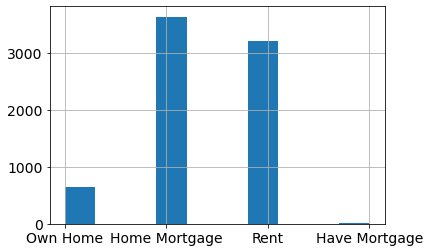

In [17]:
# проверка на уникальные данные
value_counts_column_hust(df,'Home Ownership') # домовладение

In [18]:
# Бинарные (дамми) переменные
df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'])], axis=1)
pd.get_dummies(df['Home Ownership'])

,Have Mortgage,Home Mortgage,Own Home,Rent
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
7495,0,0,0,1
7496,0,1,0,0
7497,0,0,0,1
7498,0,1,0,0


### Annual Income : годовой доход

(1161660.0    4
 1058376.0    4
 1338113.0    4
 1043651.0    4
 969475.0     4
             ..
 1141254.0    1
 7907382.0    1
 1534478.0    1
 972040.0     1
 1654786.0    1
 Name: Annual Income, Length: 5478, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f7c77910>)

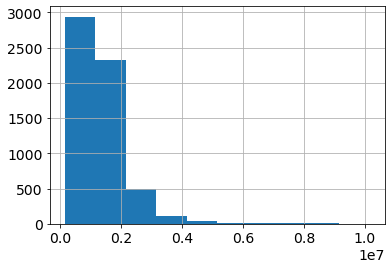

In [19]:
value_counts_column_hust(df,'Annual Income')

In [20]:
df['Annual Income'].mean()

1366391.7201749957

In [21]:
# убираем пропуски
passes(df,'Annual Income',df['Annual Income'].mean())
passes(df_test,'Annual Income',df_test['Annual Income'].mean())

NAN (Annual Income) = 0
NAN (Annual Income) = 0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Have Mortgage,Home Mortgage,Own Home,Rent,Annual Income NAN
0,Rent,1.366922e+06,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,Short Term,162470.0,105906.0,6813.0,NaN,0,0,0,1,0
1,Rent,2.318380e+05,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,...,Short Term,78298.0,46037.0,2318.0,699.0,0,0,0,1,0
2,Home Mortgage,1.152540e+06,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,...,Short Term,200178.0,146490.0,18729.0,7260.0,0,1,0,0,0
3,Home Mortgage,1.220313e+06,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,Short Term,217382.0,213199.0,27559.0,739.0,0,1,0,0,0
4,Home Mortgage,2.340952e+06,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,...,Long Term,777634.0,425391.0,42605.0,706.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1.020053e+06,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,...,Short Term,99999999.0,162735.0,15046.0,745.0,0,1,0,0,0
2496,Home Mortgage,1.366922e+06,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,...,Short Term,468512.0,1439269.0,32996.0,NaN,0,1,0,0,0
2497,Home Mortgage,1.171806e+06,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,...,Short Term,430496.0,676438.0,36912.0,695.0,0,1,0,0,0
2498,Rent,7.235200e+05,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,...,Short Term,257774.0,391248.0,13506.0,744.0,0,0,0,1,0


In [22]:
df_cat = df.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Annual Income']].rename(columns={
    'Annual Income': 'target_encode_Home_Ownership_Annual_Income'
})
df_cat = pd.DataFrame(df_cat)

df_cat

,Home Ownership,target_encode_Home_Ownership_Annual_Income
0,Have Mortgage,1.184350e+06
1,Home Mortgage,1.520934e+06
2,Own Home,1.212084e+06
3,Rent,1.222806e+06


In [23]:
df = df.merge(df_cat, on='Home Ownership', how='left')
df_test = df_test.merge(df_cat, on='Home Ownership', how='left')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Home Ownership                              7500 non-null   object 
 1   Annual Income                               7500 non-null   float64
 2   Years in current job                        7129 non-null   object 
 3   Tax Liens                                   7500 non-null   float64
 4   Number of Open Accounts                     7500 non-null   float64
 5   Years of Credit History                     7500 non-null   float64
 6   Maximum Open Credit                         7500 non-null   float64
 7   Number of Credit Problems                   7500 non-null   float64
 8   Months since last delinquent                3419 non-null   float64
 9   Bankruptcies                                7486 non-null   float64
 10  Purpose     

### Years in current job : количество лет на текущем месте работы

(10+ years    2332
 2 years       705
 3 years       620
 < 1 year      563
 5 years       516
 1 year        504
 4 years       469
 6 years       426
 7 years       396
 8 years       339
 9 years       259
 Name: Years in current job, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f7e96700>)

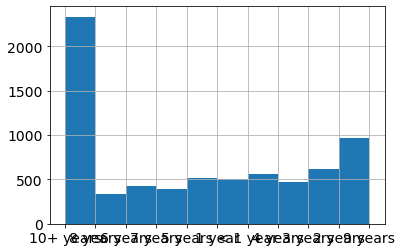

In [25]:
value_counts_column_hust(df,'Years in current job')

In [26]:
# убираем пропуски
passes(df,'Years in current job','< 1 year')
passes(df_test,'Years in current job','< 1 year')

NAN (Years in current job) = 0
NAN (Years in current job) = 0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Have Mortgage,Home Mortgage,Own Home,Rent,Annual Income NAN,target_encode_Home_Ownership_Annual_Income,Years in current job NAN
0,Rent,1.366922e+06,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,105906.0,6813.0,NaN,0,0,0,1,0,1.222806e+06,0
1,Rent,2.318380e+05,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,...,46037.0,2318.0,699.0,0,0,0,1,0,1.222806e+06,0
2,Home Mortgage,1.152540e+06,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,...,146490.0,18729.0,7260.0,0,1,0,0,0,1.520934e+06,0
3,Home Mortgage,1.220313e+06,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,213199.0,27559.0,739.0,0,1,0,0,0,1.520934e+06,0
4,Home Mortgage,2.340952e+06,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,...,425391.0,42605.0,706.0,0,1,0,0,0,1.520934e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1.020053e+06,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,...,162735.0,15046.0,745.0,0,1,0,0,0,1.520934e+06,0
2496,Home Mortgage,1.366922e+06,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,...,1439269.0,32996.0,NaN,0,1,0,0,0,1.520934e+06,0
2497,Home Mortgage,1.171806e+06,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,...,676438.0,36912.0,695.0,0,1,0,0,0,1.520934e+06,0
2498,Rent,7.235200e+05,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,...,391248.0,13506.0,744.0,0,0,0,1,0,1.222806e+06,0


In [27]:
# Перевод в порядковые числа
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df['Years in current job le'] = 0
df_test['Years in current job le'] = 0
df['Years in current job le'] = le1.fit_transform(df['Years in current job'])
df_test['Years in current job le'] = le1.transform(df_test['Years in current job'])
df['Years in current job le'].value_counts()

1     2332
10     934
2      705
3      620
5      516
0      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job le, dtype: int64

In [28]:
# Бинарные (дамми) переменные
df = pd.concat([df, pd.get_dummies(df['Years in current job'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Years in current job'])], axis=1)
pd.get_dummies(df['Years in current job'])

,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,0,0,0,0,0,0,0,1
7496,1,0,0,0,0,0,0,0,0,0,0
7497,0,0,0,0,0,0,1,0,0,0,0
7498,0,0,0,0,0,0,0,0,0,0,1


In [29]:
df = df.rename(columns={'< 1 year': 'less 1 year'})
df_test = df_test.rename(columns={'< 1 year': 'less 1 year'})

### Tax Liens : налоговые обременения

(0.0    7366
 1.0      83
 2.0      30
 3.0      10
 4.0       6
 5.0       2
 6.0       2
 7.0       1
 Name: Tax Liens, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f815beb0>)

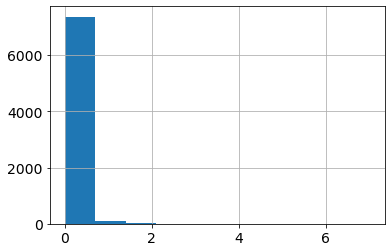

In [30]:
value_counts_column_hust(df,'Tax Liens') #налоговые обременения

In [31]:
df['Tax Liens_group'] = 0
df.loc[df['Tax Liens'] == 0, 'Tax Liens_group'] = 0
df.loc[df['Tax Liens'] >= 1, 'Tax Liens_group'] = 1

df_test['Tax Liens_group'] = 0
df_test.loc[df_test['Tax Liens'] == 0, 'Tax Liens_group'] = 0
df_test.loc[df_test['Tax Liens'] >= 1, 'Tax Liens_group'] = 1

### Number of Open Accounts : количество открытых счетов

(9.0     728
 11.0    692
 10.0    677
 8.0     638
 7.0     613
 12.0    562
 6.0     504
 13.0    465
 14.0    420
 5.0     325
 15.0    313
 16.0    265
 17.0    232
 4.0     212
 18.0    143
 19.0    139
 3.0      95
 20.0     93
 21.0     78
 23.0     59
 24.0     50
 22.0     49
 25.0     32
 2.0      28
 28.0     14
 27.0     14
 26.0     12
 30.0     11
 29.0     10
 32.0      6
 33.0      6
 31.0      6
 34.0      2
 37.0      2
 43.0      1
 35.0      1
 41.0      1
 38.0      1
 42.0      1
 Name: Number of Open Accounts, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f81bf6d0>)

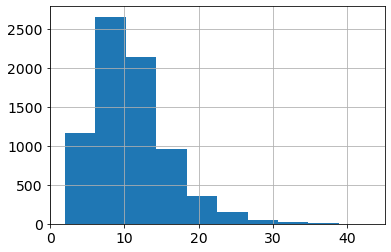

In [32]:
value_counts_column_hust(df,'Number of Open Accounts')

In [33]:
quant975(df, 'Number of Open Accounts', df['Number of Open Accounts'].quantile(.975))

23.0

In [34]:
quant975(df_test, 'Number of Open Accounts', df_test['Number of Open Accounts'].quantile(.975))

22.52500000000009

In [35]:
df['Number of Open Accounts'].sort_values().unique()

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23.])

### Years of Credit History : количество лет кредитной истории

(15.0    104
 16.0     99
 16.5     91
 17.0     86
 17.5     83
        ... 
 43.2      1
 4.9       1
 39.5      1
 42.4      1
 39.8      1
 Name: Years of Credit History, Length: 408, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f822fd00>)

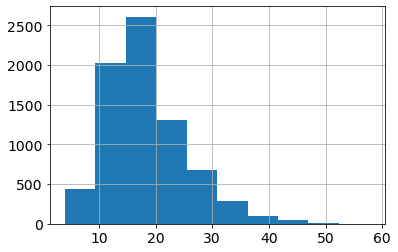

In [36]:
value_counts_column_hust(df,'Years of Credit History')

In [37]:
quant975(df, 'Years of Credit History', df['Years of Credit History'].quantile(.975))

35.2

In [38]:
quant975(df_test, 'Years of Credit History', df_test['Years of Credit History'].quantile(.975))

37.05250000000001

### Maximum Open Credit : наибольший открытый кредит

(0.0          65
 319110.0      5
 334796.0      3
 607046.0      3
 294030.0      3
              ..
 534600.0      1
 1026124.0     1
 77066.0       1
 780164.0      1
 350768.0      1
 Name: Maximum Open Credit, Length: 6963, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f829f190>)

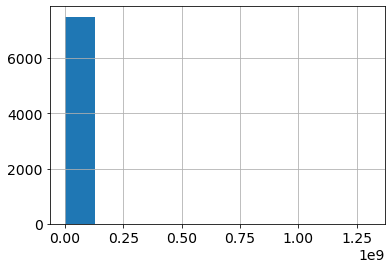

In [39]:
value_counts_column_hust(df,'Maximum Open Credit')

In [40]:
df['Maximum Open Credit_group'] = 0
df.loc[df['Maximum Open Credit'] <= 800000, 'Maximum Open Credit_group'] = 0
df.loc[df['Maximum Open Credit'] > 800000, 'Maximum Open Credit_group'] = 1

df_test['Maximum Open Credit_group'] = 0
df_test.loc[df_test['Maximum Open Credit'] <= 800000, 'Maximum Open Credit_group'] = 0
df_test.loc[df_test['Maximum Open Credit'] > 800000, 'Maximum Open Credit_group'] = 1

(0    5657
 1    1843
 Name: Maximum Open Credit_group, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f830e1f0>)

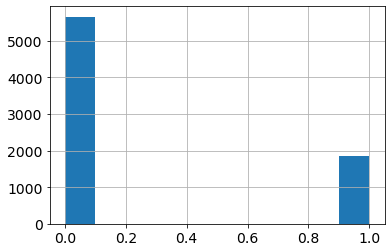

In [41]:
value_counts_column_hust(df,'Maximum Open Credit_group')

### Number of Credit Problems : количество проблем с кредитом

(0.0    6469
 1.0     882
 2.0      93
 3.0      35
 4.0       9
 5.0       7
 6.0       4
 7.0       1
 Name: Number of Credit Problems, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f830af10>)

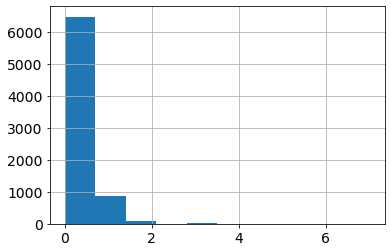

In [42]:
value_counts_column_hust(df,'Number of Credit Problems')

In [43]:
# Бинарные (дамми) переменные
df = pd.concat([df, pd.get_dummies(df['Number of Credit Problems'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Number of Credit Problems'])], axis=1)
pd.get_dummies(df['Number of Credit Problems'])

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
7495,1,0,0,0,0,0,0,0
7496,1,0,0,0,0,0,0,0
7497,1,0,0,0,0,0,0,0
7498,1,0,0,0,0,0,0,0


### Months since last delinquent : количество месяцев с последней просрочки платежа

(14.0     76
 29.0     71
 8.0      68
 33.0     68
 13.0     65
          ..
 86.0      1
 92.0      1
 118.0     1
 84.0      1
 91.0      1
 Name: Months since last delinquent, Length: 89, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f822b160>)

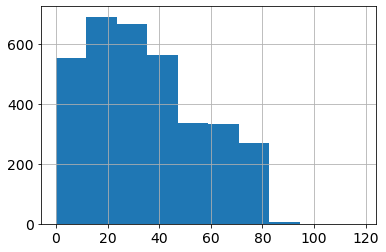

In [44]:
value_counts_column_hust(df,'Months since last delinquent')

In [45]:
# убираем пропуски
passes(df,'Months since last delinquent',0)
passes(df_test,'Months since last delinquent',0)

NAN (Months since last delinquent) = 0
NAN (Months since last delinquent) = 0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Maximum Open Credit_group,0.0,1.0,2.0,3.0,4.0,5.0,7.0,15.0,Months since last delinquent NAN
0,Rent,1.366922e+06,4 years,0.0,9.000,12.5,220968.0,0.0,70.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,Rent,2.318380e+05,1 year,0.0,6.000,32.7,55946.0,0.0,8.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,Home Mortgage,1.152540e+06,3 years,0.0,10.000,13.7,204600.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,Home Mortgage,1.220313e+06,10+ years,0.0,16.000,17.0,456302.0,0.0,70.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,Home Mortgage,2.340952e+06,6 years,0.0,11.000,23.6,1207272.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1.020053e+06,10+ years,0.0,14.000,29.1,559152.0,1.0,68.0,1.0,...,0,0,1,0,0,0,0,0,0,0
2496,Home Mortgage,1.366922e+06,2 years,0.0,15.000,17.0,1737780.0,0.0,77.0,0.0,...,1,1,0,0,0,0,0,0,0,0
2497,Home Mortgage,1.171806e+06,2 years,0.0,22.525,12.8,1706430.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
2498,Rent,7.235200e+05,10+ years,0.0,14.000,28.8,945780.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0


### Bankruptcies : банкротства

(0.0    6660
 1.0     786
 2.0      31
 3.0       7
 4.0       2
 Name: Bankruptcies, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f7d6fc10>)

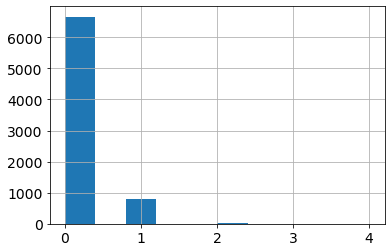

In [46]:
value_counts_column_hust(df,'Bankruptcies')

In [47]:
# убираем пропуски
passes(df,'Bankruptcies',0)
passes(df_test,'Bankruptcies',0)

NAN (Bankruptcies) = 0
NAN (Bankruptcies) = 0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,0.0,1.0,2.0,3.0,4.0,5.0,7.0,15.0,Months since last delinquent NAN,Bankruptcies NAN
0,Rent,1.366922e+06,4 years,0.0,9.000,12.5,220968.0,0.0,70.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,Rent,2.318380e+05,1 year,0.0,6.000,32.7,55946.0,0.0,8.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,Home Mortgage,1.152540e+06,3 years,0.0,10.000,13.7,204600.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,Home Mortgage,1.220313e+06,10+ years,0.0,16.000,17.0,456302.0,0.0,70.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,Home Mortgage,2.340952e+06,6 years,0.0,11.000,23.6,1207272.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1.020053e+06,10+ years,0.0,14.000,29.1,559152.0,1.0,68.0,1.0,...,0,1,0,0,0,0,0,0,0,0
2496,Home Mortgage,1.366922e+06,2 years,0.0,15.000,17.0,1737780.0,0.0,77.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2497,Home Mortgage,1.171806e+06,2 years,0.0,22.525,12.8,1706430.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2498,Rent,7.235200e+05,10+ years,0.0,14.000,28.8,945780.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [48]:
# Бинарные (дамми) переменные
df = pd.concat([df, pd.get_dummies(df['Bankruptcies'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Bankruptcies'])], axis=1)
pd.get_dummies(df['Bankruptcies'])

,0.0,1.0,2.0,3.0,4.0
0,0,1,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
7495,1,0,0,0,0
7496,1,0,0,0,0
7497,1,0,0,0,0
7498,1,0,0,0,0


### Purpose : цель кредита

(debt consolidation      5944
 other                    665
 home improvements        412
 business loan            129
 buy a car                 96
 medical bills             71
 major purchase            40
 take a trip               37
 buy house                 34
 small business            26
 wedding                   15
 moving                    11
 educational expenses      10
 vacation                   8
 renewable energy           2
 Name: Purpose, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f8059b80>)

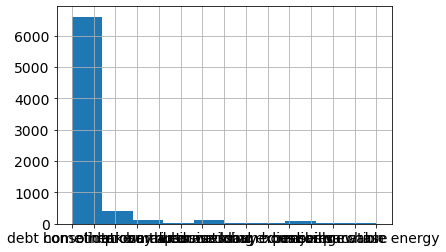

In [49]:
value_counts_column_hust(df,'Purpose')

In [50]:
# Перевод в порядковые числа
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df['Purpose le'] = 0
df_test['Purpose le'] = 0
df['Purpose le'] = le1.fit_transform(df['Purpose'])
df_test['Purpose le'] = le1.fit_transform(df_test['Purpose'])
df['Purpose le'].value_counts()

3     5944
9      665
5      412
0      129
1       96
7       71
6       40
12      37
2       34
11      26
14      15
8       11
4       10
13       8
10       2
Name: Purpose le, dtype: int64

### Term : срок кредита

(Short Term    5556
 Long Term     1944
 Name: Term, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f82956a0>)

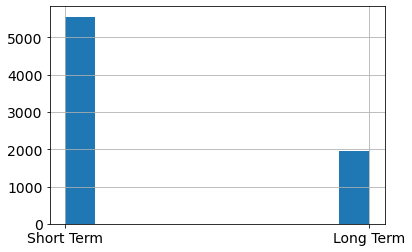

In [51]:
value_counts_column_hust(df,'Term')

In [52]:
# убираем пропуски
passes(df,'Term','Short Term')
passes(df_test,'Term','Short Term')

NAN (Term) = 0
NAN (Term) = 0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Months since last delinquent NAN,Bankruptcies NAN,0.0,1.0,2.0,3.0,4.0,5.0,Purpose le,Term NAN
0,Rent,1.366922e+06,4 years,0.0,9.000,12.5,220968.0,0.0,70.0,0.0,...,0,0,1,0,0,0,0,0,3,0
1,Rent,2.318380e+05,1 year,0.0,6.000,32.7,55946.0,0.0,8.0,0.0,...,0,0,1,0,0,0,0,0,4,0
2,Home Mortgage,1.152540e+06,3 years,0.0,10.000,13.7,204600.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,3,0
3,Home Mortgage,1.220313e+06,10+ years,0.0,16.000,17.0,456302.0,0.0,70.0,0.0,...,0,0,1,0,0,0,0,0,3,0
4,Home Mortgage,2.340952e+06,6 years,0.0,11.000,23.6,1207272.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1.020053e+06,10+ years,0.0,14.000,29.1,559152.0,1.0,68.0,1.0,...,0,0,0,1,0,0,0,0,3,0
2496,Home Mortgage,1.366922e+06,2 years,0.0,15.000,17.0,1737780.0,0.0,77.0,0.0,...,0,0,1,0,0,0,0,0,3,0
2497,Home Mortgage,1.171806e+06,2 years,0.0,22.525,12.8,1706430.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,3,0
2498,Rent,7.235200e+05,10+ years,0.0,14.000,28.8,945780.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,3,0


In [53]:
# Перевод в порядковые числа
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df['Term le'] = 0
df_test['Term le'] = 0
df['Term le'] = le1.fit_transform(df['Term'])
df_test['Term le'] = le1.fit_transform(df_test['Term'])
df['Term le'].value_counts()

1    5556
0    1944
Name: Term le, dtype: int64

In [54]:
# Бинарные (дамми) переменные
df = pd.concat([df, pd.get_dummies(df['Term'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Term'])], axis=1)
pd.get_dummies(df['Term'])

,Long Term,Short Term
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
7495,0,1
7496,1,0
7497,0,1
7498,0,1


In [55]:
df_cat = df.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Term le']].rename(columns={
    'Term le': 'target_encode_Home_Ownership_Term le'
})
df_cat = pd.DataFrame(df_cat)

df_cat

,Home Ownership,target_encode_Home_Ownership_Term le
0,Have Mortgage,0.916667
1,Home Mortgage,0.695078
2,Own Home,0.734158
3,Rent,0.793383


In [56]:
df = df.merge(df_cat, on='Home Ownership', how='left')
df_test = df_test.merge(df_cat, on='Home Ownership', how='left')

### Current Loan Amount : текущая сумма кредита

(99999999.0    870
 89298.0         6
 218064.0        6
 216106.0        5
 270226.0        5
              ... 
 490006.0        1
 404756.0        1
 194414.0        1
 420376.0        1
 33792.0         1
 Name: Current Loan Amount, Length: 5386, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f83a2cd0>)

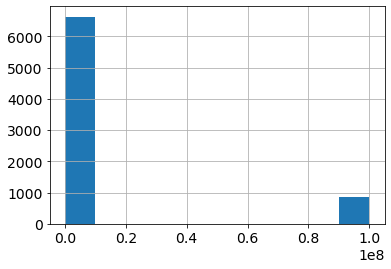

In [57]:
value_counts_column_hust(df,'Current Loan Amount')

In [58]:
#df.loc[df['Current Loan Amount'] >= 99999999, 'Current Loan Amount'] = df['Current Loan Amount'].median()

In [59]:
#value_counts_column_hust(df,'Current Loan Amount')

### Current Credit Balance : текущий кредитный баланс 

(0.0         53
 191710.0     5
 53580.0      4
 106818.0     4
 155059.0     4
             ..
 229672.0     1
 349467.0     1
 116223.0     1
 797240.0     1
 189905.0     1
 Name: Current Credit Balance, Length: 6592, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f841fd60>)

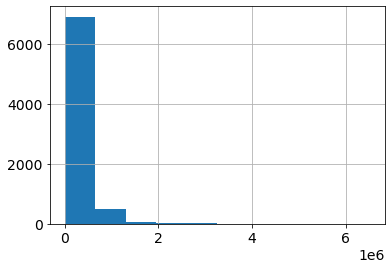

In [60]:
value_counts_column_hust(df,'Current Credit Balance')

### Monthly Debt : ежемесячный долг

(0.0        6
 19222.0    4
 19667.0    4
 9525.0     3
 22364.0    3
           ..
 12897.0    1
 27541.0    1
 23227.0    1
 55957.0    1
 17.0       1
 Name: Monthly Debt, Length: 6716, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f849d490>)

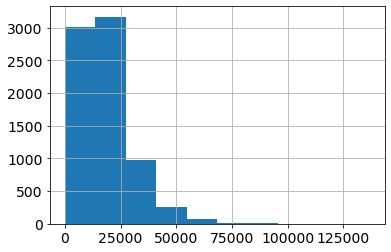

In [61]:
value_counts_column_hust(df,'Monthly Debt')

### Credit Score : баллы кредитного рейтинга

(740.0     169
 747.0     168
 748.0     157
 745.0     152
 741.0     151
          ... 
 602.0       1
 616.0       1
 585.0       1
 620.0       1
 7010.0      1
 Name: Credit Score, Length: 268, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9f84f0e20>)

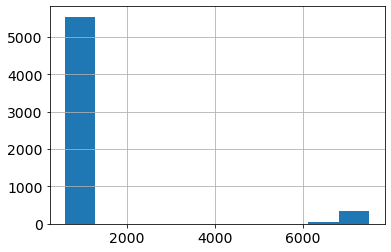

In [62]:
value_counts_column_hust(df,'Credit Score')

In [63]:
# убираем пропуски
passes(df,'Credit Score',0)#df['Credit Score'].mean()
passes(df_test,'Credit Score',0)#df_test['Credit Score'].mean()

NAN (Credit Score) = 0
NAN (Credit Score) = 0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,3.0,4.0,5.0,Purpose le,Term NAN,Term le,Long Term,Short Term,target_encode_Home_Ownership_Term le,Credit Score NAN
0,Rent,1.366922e+06,4 years,0.0,9.000,12.5,220968.0,0.0,70.0,0.0,...,0,0,0,3,0,1,0,1,0.793383,0
1,Rent,2.318380e+05,1 year,0.0,6.000,32.7,55946.0,0.0,8.0,0.0,...,0,0,0,4,0,1,0,1,0.793383,0
2,Home Mortgage,1.152540e+06,3 years,0.0,10.000,13.7,204600.0,0.0,0.0,0.0,...,0,0,0,3,0,1,0,1,0.695078,0
3,Home Mortgage,1.220313e+06,10+ years,0.0,16.000,17.0,456302.0,0.0,70.0,0.0,...,0,0,0,3,0,1,0,1,0.695078,0
4,Home Mortgage,2.340952e+06,6 years,0.0,11.000,23.6,1207272.0,0.0,0.0,0.0,...,0,0,0,3,0,0,1,0,0.695078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1.020053e+06,10+ years,0.0,14.000,29.1,559152.0,1.0,68.0,1.0,...,0,0,0,3,0,1,0,1,0.695078,0
2496,Home Mortgage,1.366922e+06,2 years,0.0,15.000,17.0,1737780.0,0.0,77.0,0.0,...,0,0,0,3,0,1,0,1,0.695078,0
2497,Home Mortgage,1.171806e+06,2 years,0.0,22.525,12.8,1706430.0,0.0,0.0,0.0,...,0,0,0,3,0,1,0,1,0.695078,0
2498,Rent,7.235200e+05,10+ years,0.0,14.000,28.8,945780.0,0.0,0.0,0.0,...,0,0,0,3,0,1,0,1,0.793383,0


In [64]:
df['Credit Score'].sort_values().unique()

array([   0.,  585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,
        597.,  598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,
        609.,  610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,
        618.,  619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,
        628.,  629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,
        637.,  638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,
        647.,  648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,
        656.,  657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,
        665.,  666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,
        674.,  675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,
        683.,  684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,
        692.,  693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,
        701.,  702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,
        710.,  711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,
        719.,  720.,

In [65]:
df.loc[df['Credit Score'] >= 1000, 'Credit Score'] = df['Credit Score']/10

In [66]:
df['Credit Score'].sort_values().unique()

array([  0., 585., 586., 588., 589., 590., 591., 593., 594., 597., 598.,
       599., 601., 602., 604., 606., 607., 608., 609., 610., 611., 612.,
       613., 614., 615., 616., 617., 618., 619., 620., 621., 622., 623.,
       624., 625., 626., 627., 628., 629., 630., 631., 632., 633., 634.,
       635., 636., 637., 638., 639., 640., 641., 642., 643., 644., 645.,
       646., 647., 648., 649., 650., 651., 652., 653., 654., 655., 656.,
       657., 658., 659., 660., 661., 662., 663., 664., 665., 666., 667.,
       668., 669., 670., 671., 672., 673., 674., 675., 676., 677., 678.,
       679., 680., 681., 682., 683., 684., 685., 686., 687., 688., 689.,
       690., 691., 692., 693., 694., 695., 696., 697., 698., 699., 700.,
       701., 702., 703., 704., 705., 706., 707., 708., 709., 710., 711.,
       712., 713., 714., 715., 716., 717., 718., 719., 720., 721., 722.,
       723., 724., 725., 726., 727., 728., 729., 730., 731., 732., 733.,
       734., 735., 736., 737., 738., 739., 740., 74

### Credit Default : факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [67]:
df['Credit Default'].value_counts() # факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

0    5387
1    2113
Name: Credit Default, dtype: int64

df.isnull().mean() * 100

In [68]:
df_test.isna()
df_test.isna().sum()

Home Ownership                                0
Annual Income                                 0
Years in current job                          0
Tax Liens                                     0
Number of Open Accounts                       0
Years of Credit History                       0
Maximum Open Credit                           0
Number of Credit Problems                     0
Months since last delinquent                  0
Bankruptcies                                  0
Purpose                                       0
Term                                          0
Current Loan Amount                           0
Current Credit Balance                        0
Monthly Debt                                  0
Credit Score                                  0
Have Mortgage                                 0
Home Mortgage                                 0
Own Home                                      0
Rent                                          0
Annual Income NAN                       

### Поиск выбросов

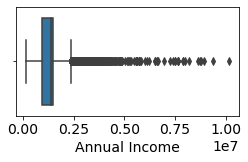

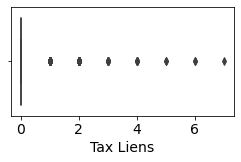

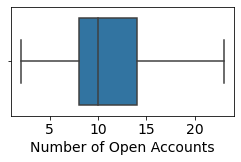

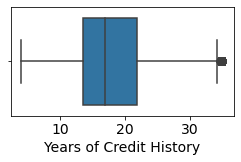

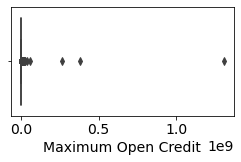

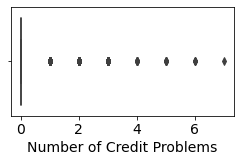

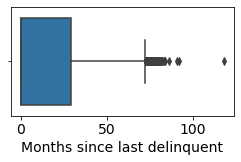

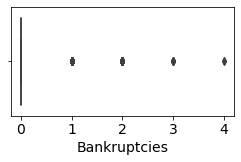

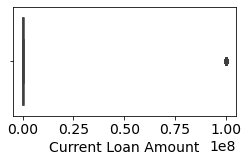

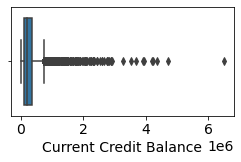

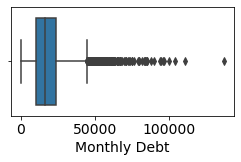

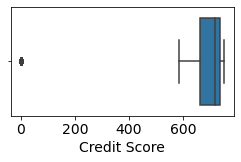

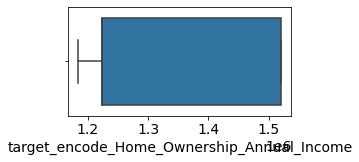

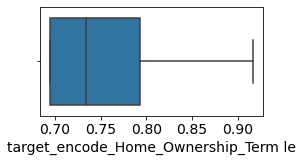

In [69]:
# Поиск выбросов
def boxplot_plt(col):
    plt.figure(figsize=(4, 2))
    sns.boxplot(df[col], whis=1.5)
    plt.xlabel(col)
    plt.show()

for col_i in df.select_dtypes(include='float64').columns:
    boxplot_plt(col_i)

### Проверка датасетов

In [70]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [71]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,2.0,3.0,4.0,Purpose le,Term NAN,Term le,Long Term,Short Term,target_encode_Home_Ownership_Term le,Credit Score NAN
0,Own Home,482087.0,< 1 year,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,3,0,1,0,1,0.734158,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,3,0,0,1,0,0.734158,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,0,0,0,3,0,1,0,1,0.695078,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,3,0,1,0,1,0.734158,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,3,0,1,0,1,0.793383,0


In [72]:
features = df.select_dtypes(include=['float64', 'float32', 'float16','int64']).columns
features

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default', 'Annual Income NAN',
       'target_encode_Home_Ownership_Annual_Income',
       'Years in current job NAN', 'Tax Liens_group',
       'Maximum Open Credit_group', 'Months since last delinquent NAN',
       'Bankruptcies NAN', 'Term NAN', 'target_encode_Home_Ownership_Term le',
       'Credit Score NAN'],
      dtype='object')

In [73]:
features= [
       'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 
       'Current Loan Amount', 
       'Current Credit Balance',
       'Monthly Debt', 
       'Credit Score', 
       #'Annual Income NAN',
       'target_encode_Home_Ownership_Annual_Income',
       'target_encode_Home_Ownership_Term le',
       #'Years in current job NAN', 'Tax Liens_group',
       #'Months since last delinquent NAN', 'Bankruptcies NAN', 'Term NAN','Credit Score NAN', 
       'Maximum Open Credit_group' 
]

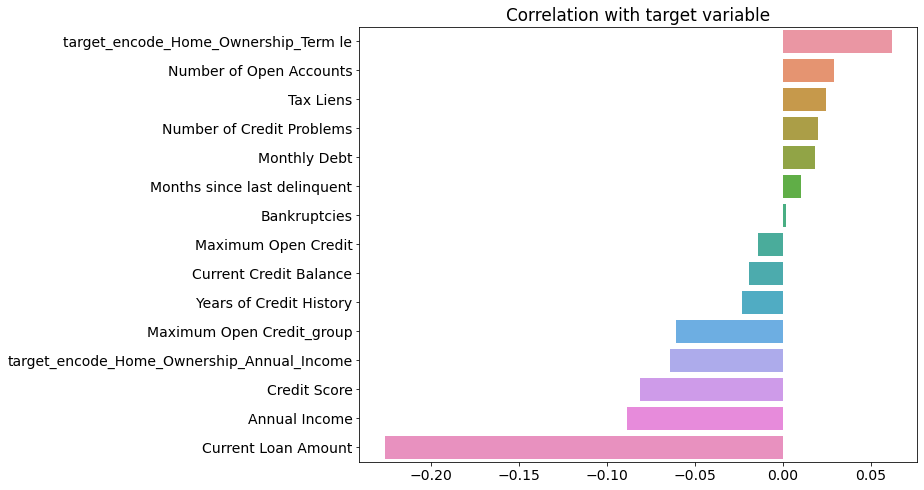

In [74]:
# Корреляция с базовыми признаками
corr_with_target = df[features + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

In [75]:
def show_plt_target(xdf, target_name, characteristic):
    #print(characteristic)
    plt.figure(figsize=(20, 6))

    sns.countplot(x=characteristic, hue=target_name, data=xdf)
    plt.title('Credit Score grouped by target variable')
    plt.legend(title='Target / ' + characteristic, loc='upper right')

    plt.show()   

    
    characteristic_with_target = xdf[[characteristic, target_name]]
    bal = characteristic_with_target[characteristic]
    characteristic_target_0 = bal[characteristic_with_target[target_name] == 0]
    characteristic_target_1 = bal[characteristic_with_target[target_name] == 1]

    plt.figure(figsize=(20, 6))

    sns.kdeplot(characteristic_target_0, shade=True, label='Нет просрочки', color='g')
    sns.kdeplot(characteristic_target_1, shade=True, label='Просрочка', color='r')

    plt.xlabel(characteristic)
    plt.title('grouped by target variable')
    plt.show()
    
    # Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка 
    #(p-value < 0,05 гипотеза о нормальности отвергается)
    print(shapiro(bal))
    
    # Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни
    print(mannwhitneyu(characteristic_target_0, characteristic_target_1))
    
    # Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график
    plt.figure(figsize=(20, 6))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(characteristic)
    ax1.set_ylabel('Count')
    ax1.set_title(characteristic)
    bal.hist()
    plt.subplot(122)
    probplot(bal, dist='norm', plot=plt)
    plt.show()
    
    #Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, 
    #но стоит ради дополнительной проверки обратиться к доверительным интервалам.
    plt.figure(figsize=(8, 5))
    sns.pointplot(x=target_name, y=characteristic, data=characteristic_with_target, capsize=.1)
    plt.title('Confidence intervals ')
    plt.show()

Оценка признака "_____" в разрезе целевой переменной

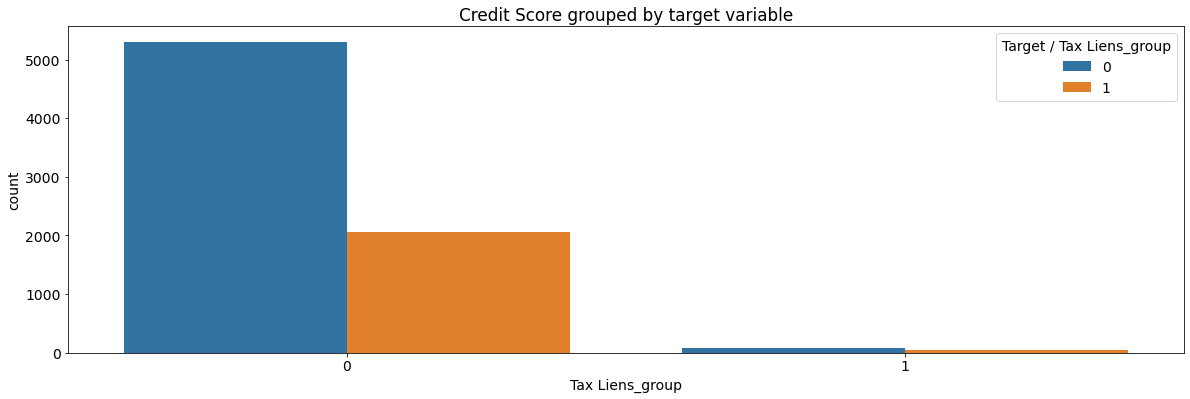

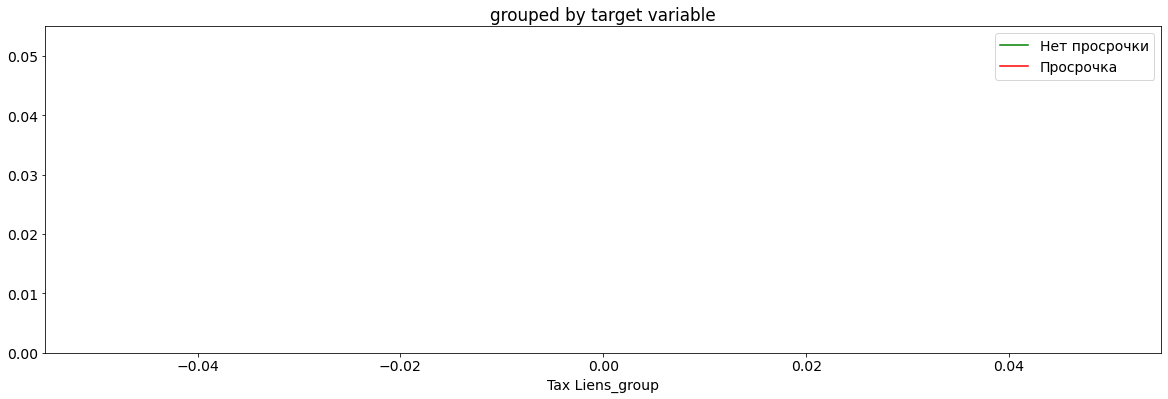

ShapiroResult(statistic=0.11024677753448486, pvalue=0.0)
MannwhitneyuResult(statistic=5652936.5, pvalue=0.0235384087012032)


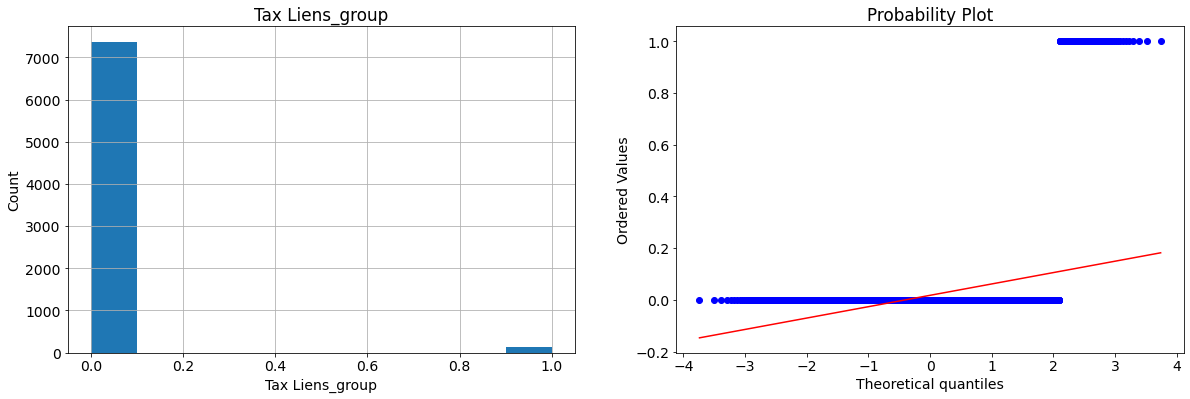

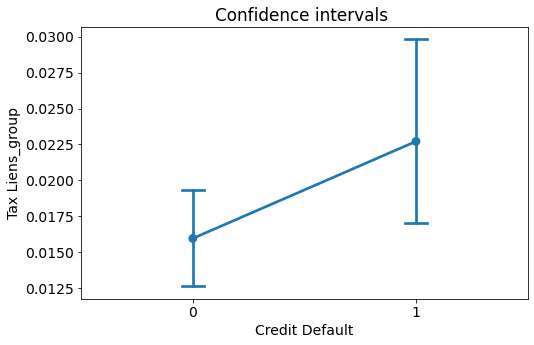

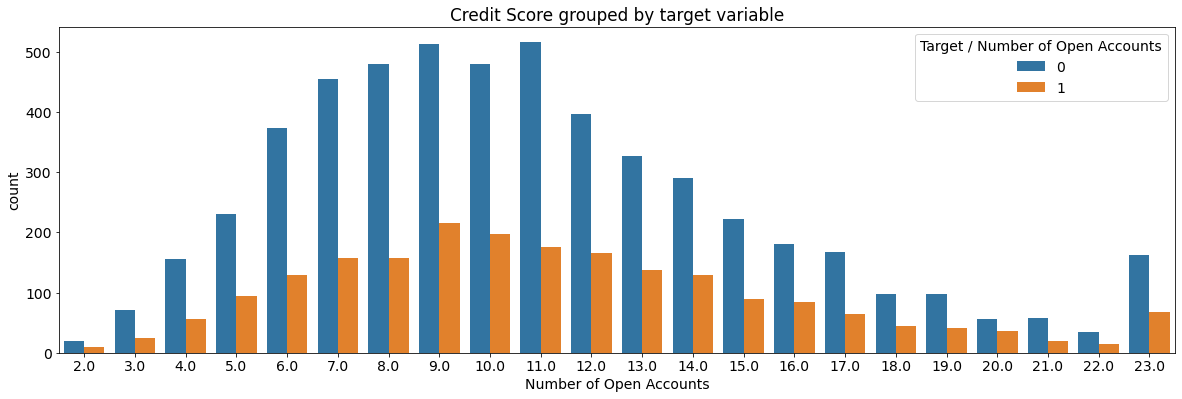

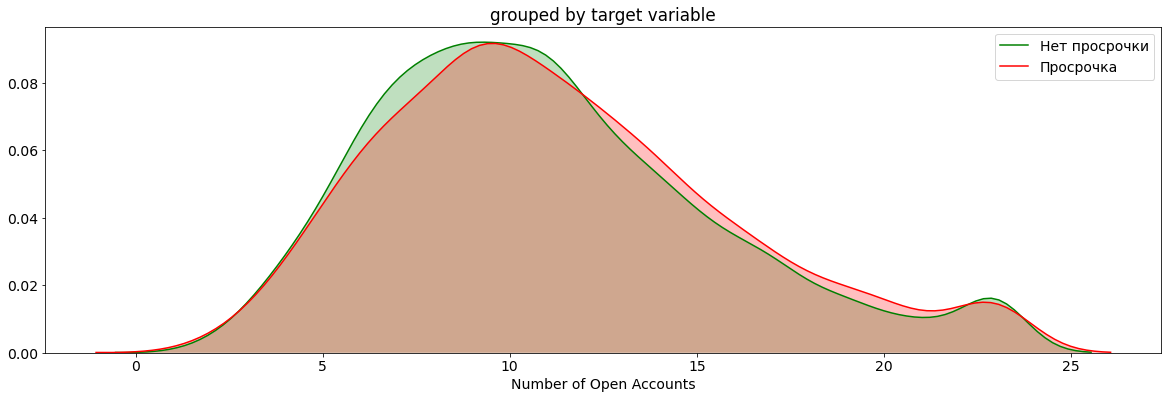

ShapiroResult(statistic=0.9579404592514038, pvalue=5.277290016647261e-42)
MannwhitneyuResult(statistic=5466695.5, pvalue=0.0037900442705002327)


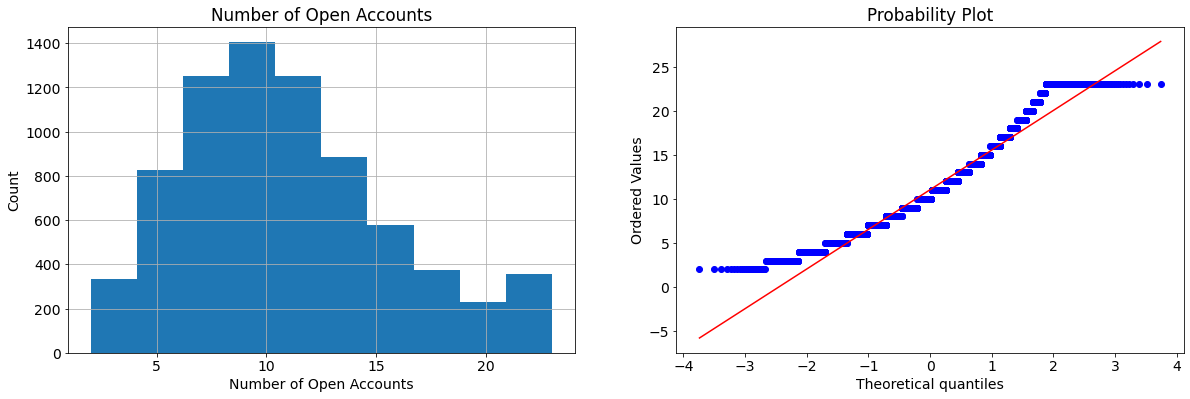

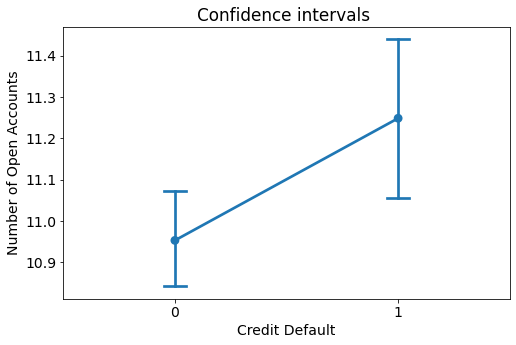

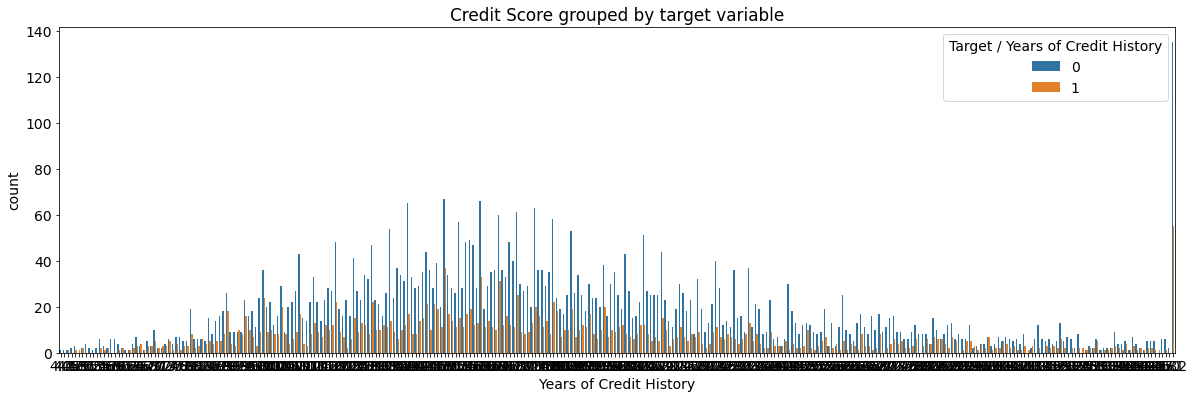

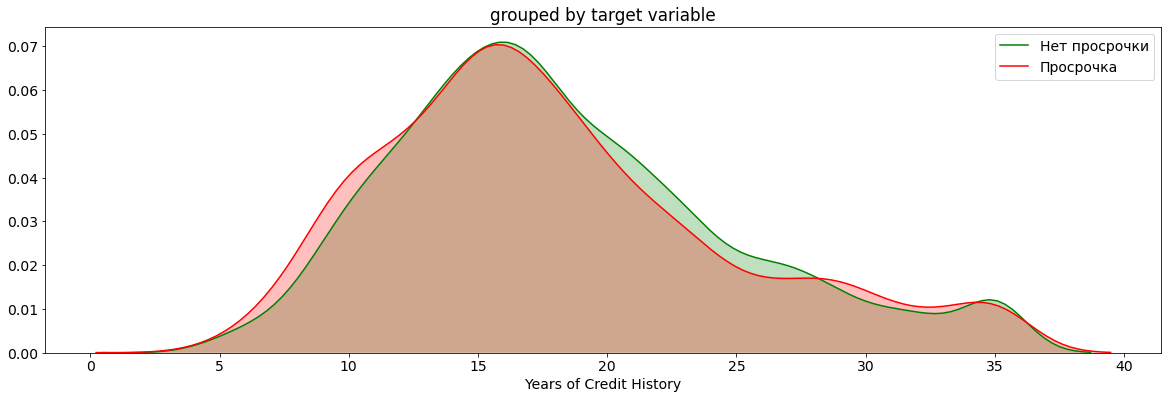

ShapiroResult(statistic=0.9589808583259583, pvalue=1.30152601366489e-41)
MannwhitneyuResult(statistic=5460782.0, pvalue=0.0031316024421382403)


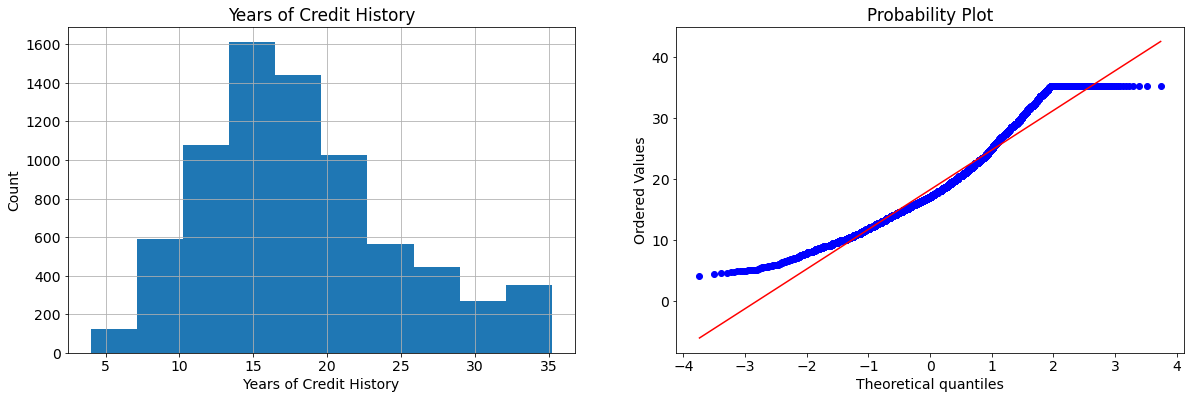

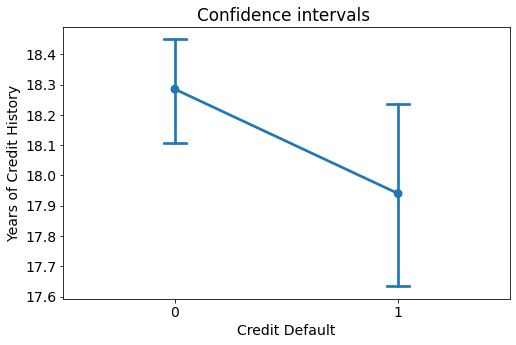

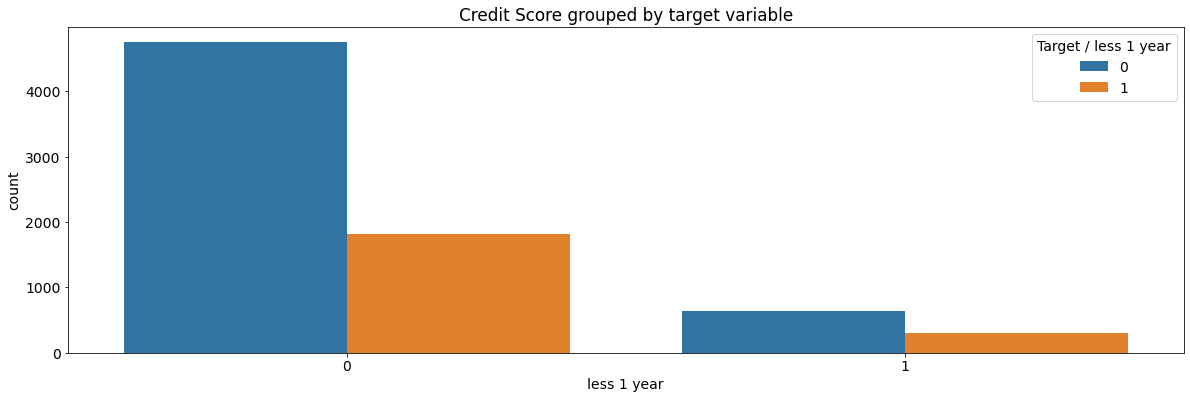

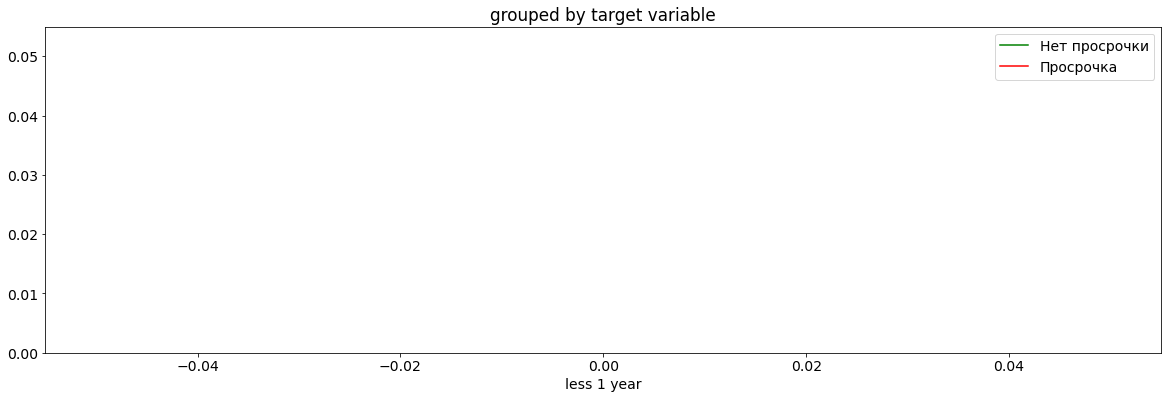

ShapiroResult(statistic=0.38663339614868164, pvalue=0.0)
MannwhitneyuResult(statistic=5568136.5, pvalue=0.005317936610388406)


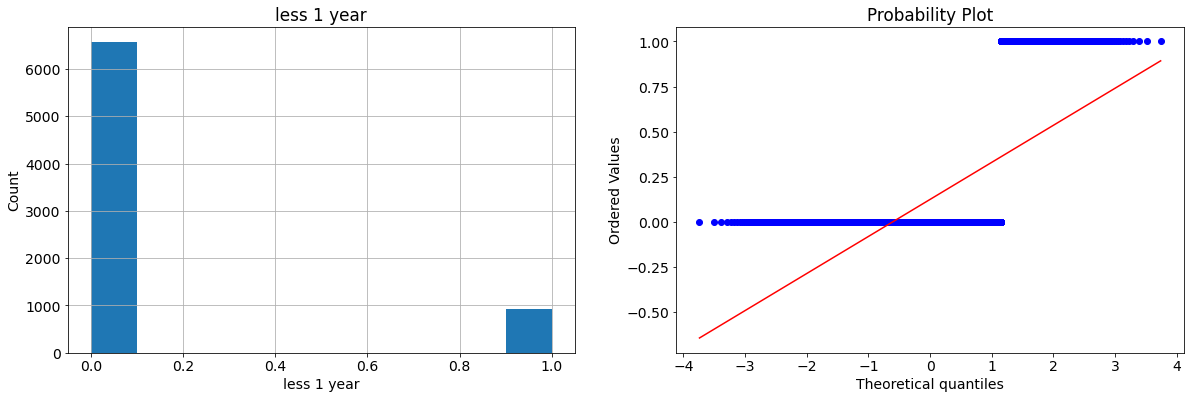

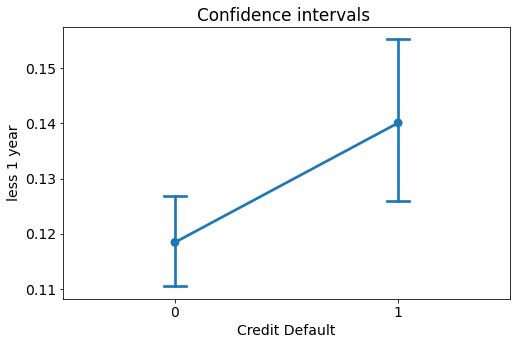

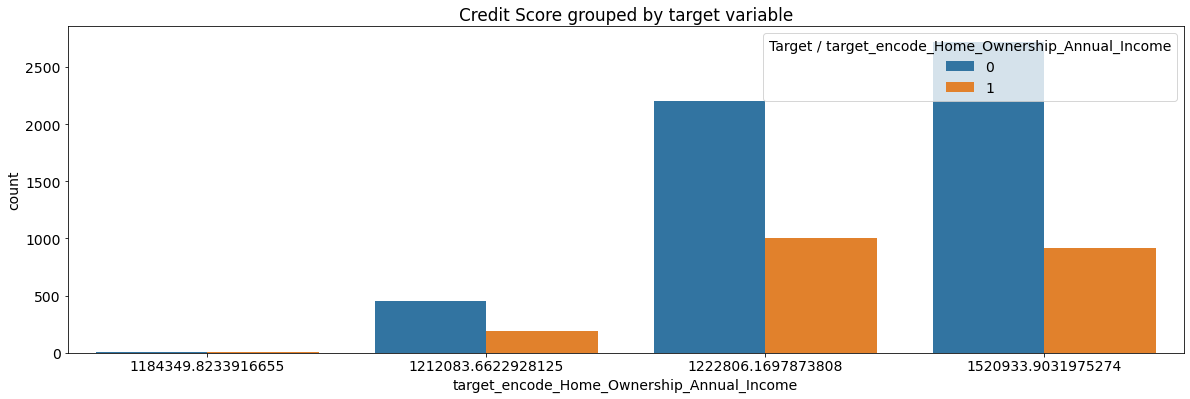

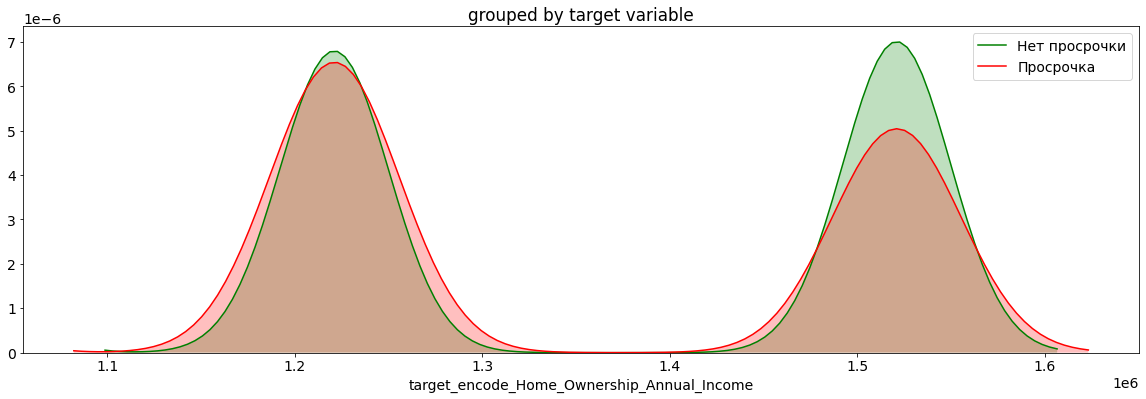

ShapiroResult(statistic=0.6476821303367615, pvalue=0.0)
MannwhitneyuResult(statistic=5304080.5, pvalue=1.6123786006045253e-07)


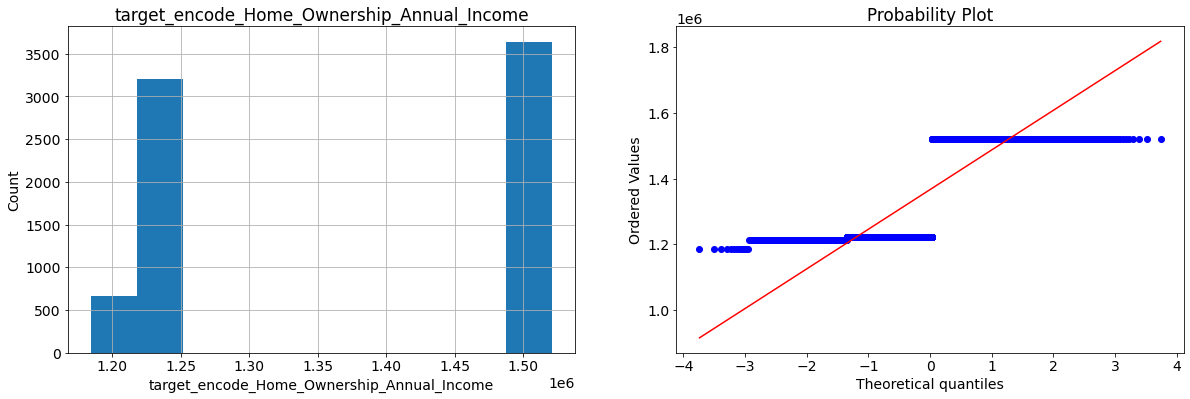

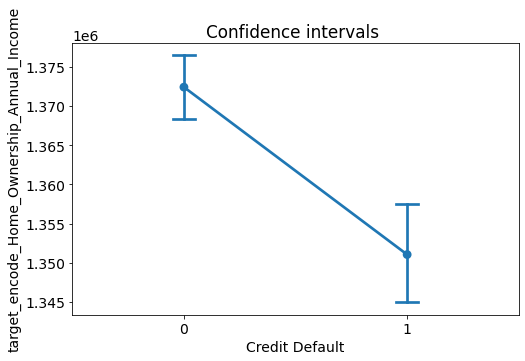

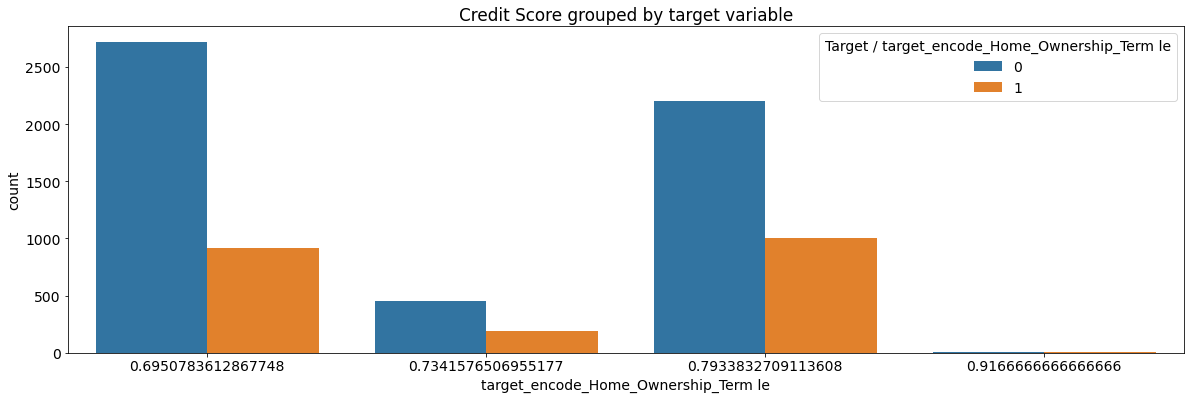

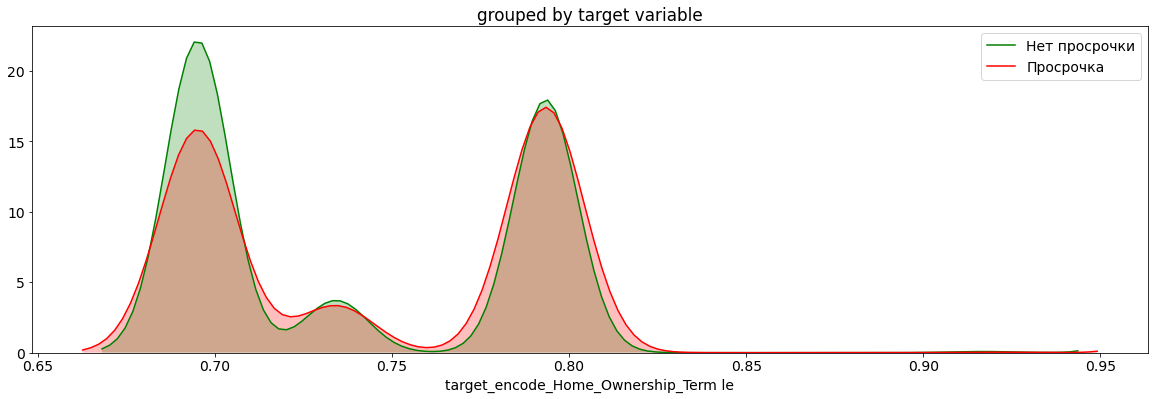

ShapiroResult(statistic=0.6928724050521851, pvalue=0.0)
MannwhitneyuResult(statistic=5270307.5, pvalue=1.384775295362486e-08)


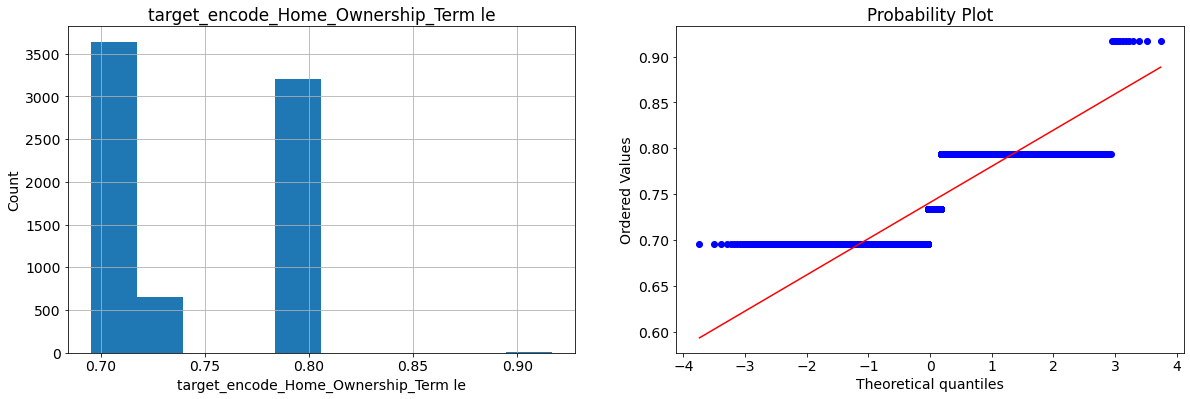

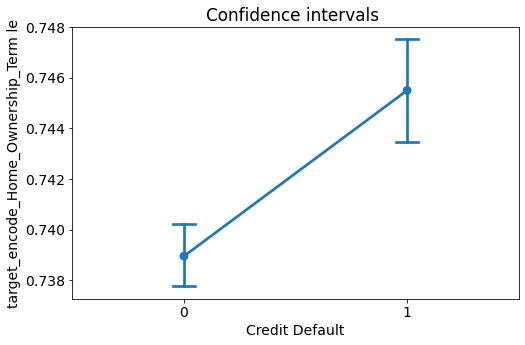

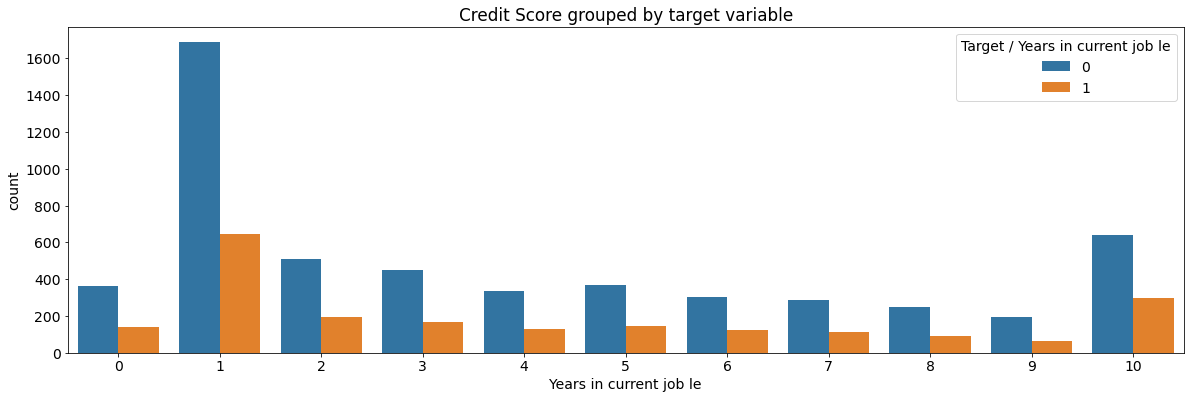

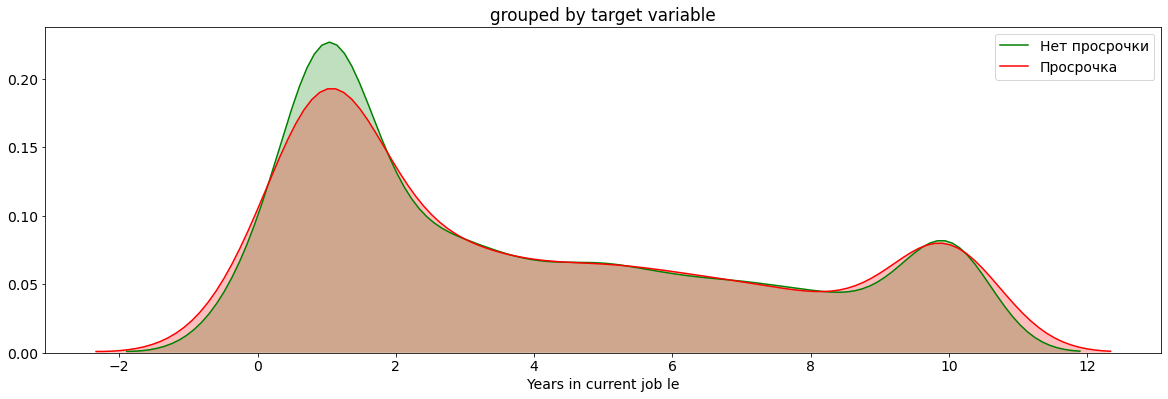

ShapiroResult(statistic=0.8564678430557251, pvalue=0.0)
MannwhitneyuResult(statistic=5579454.0, pvalue=0.08844749382965239)


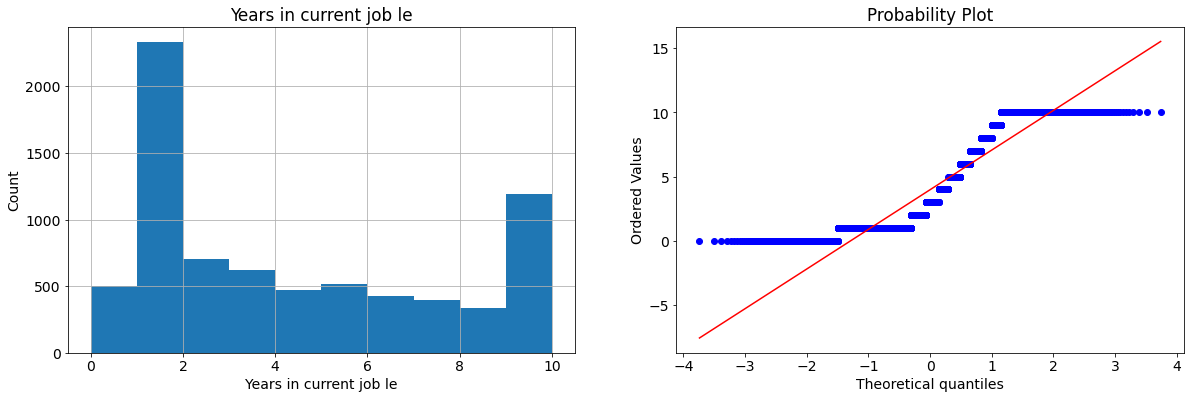

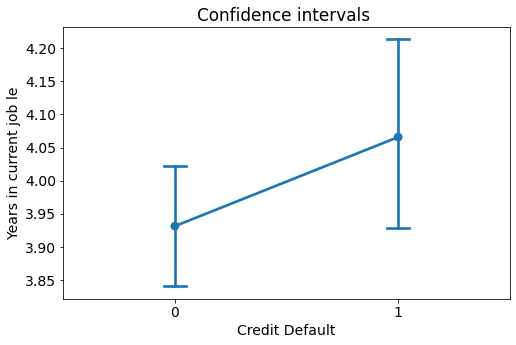

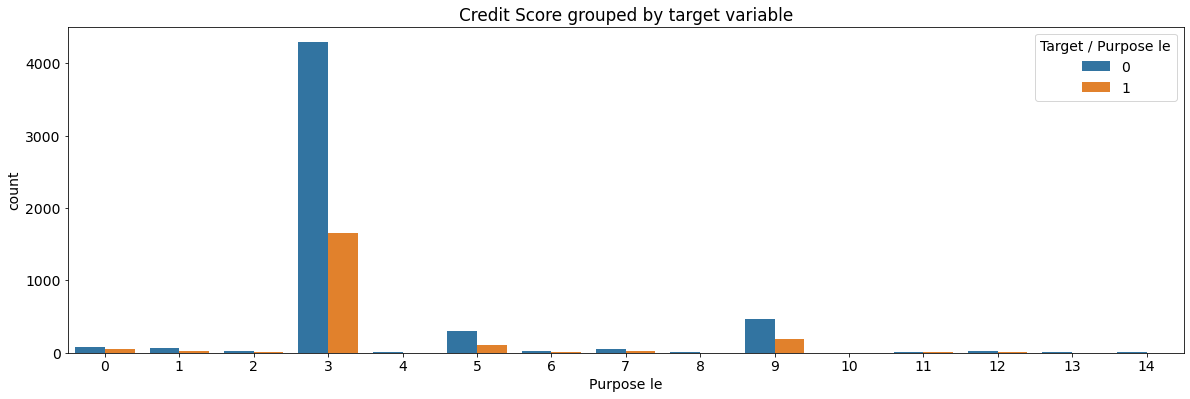

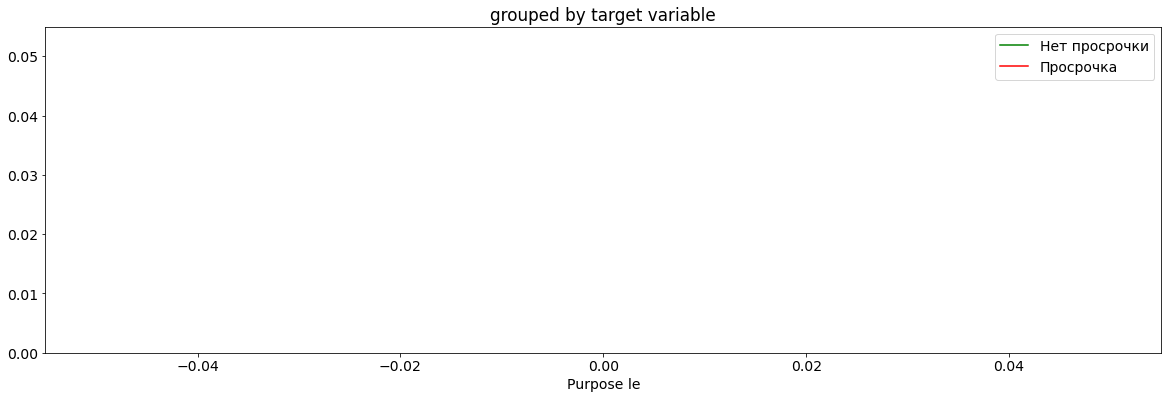

ShapiroResult(statistic=0.5467673540115356, pvalue=0.0)
MannwhitneyuResult(statistic=5674804.5, pvalue=0.3907824877430847)


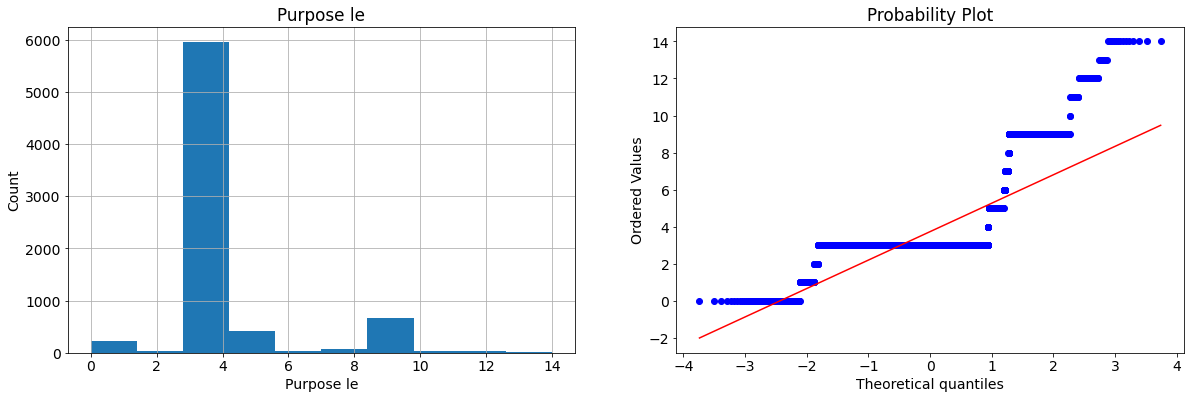

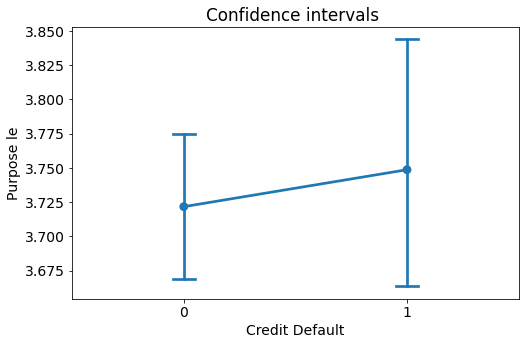

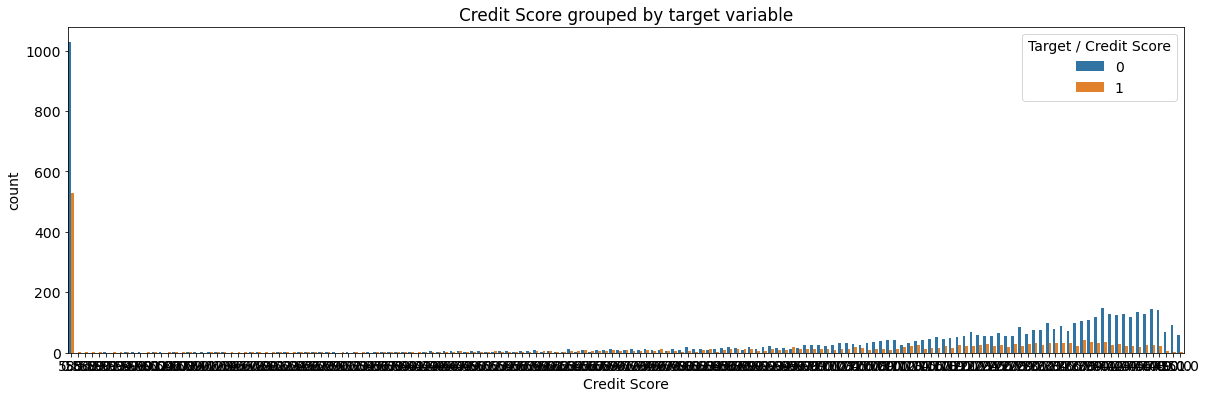

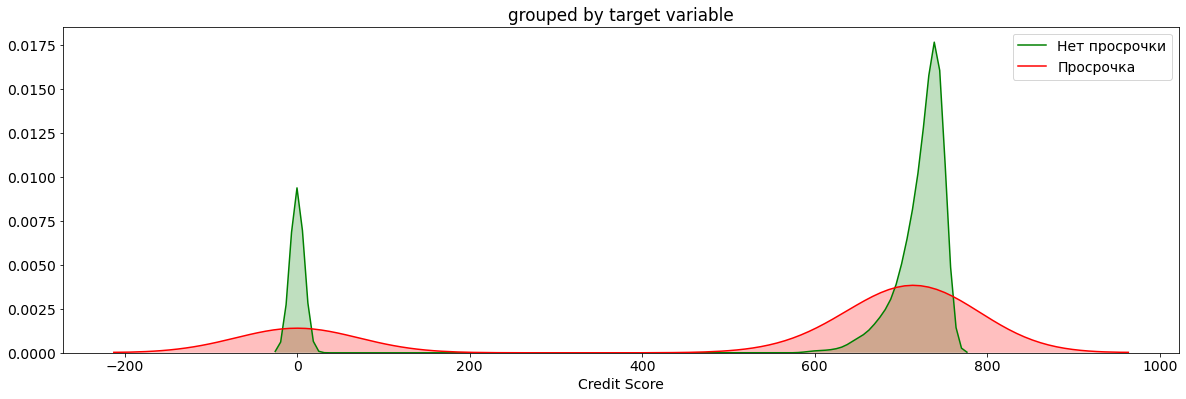

ShapiroResult(statistic=0.5638941526412964, pvalue=0.0)
MannwhitneyuResult(statistic=4406458.0, pvalue=3.6697354935175846e-53)


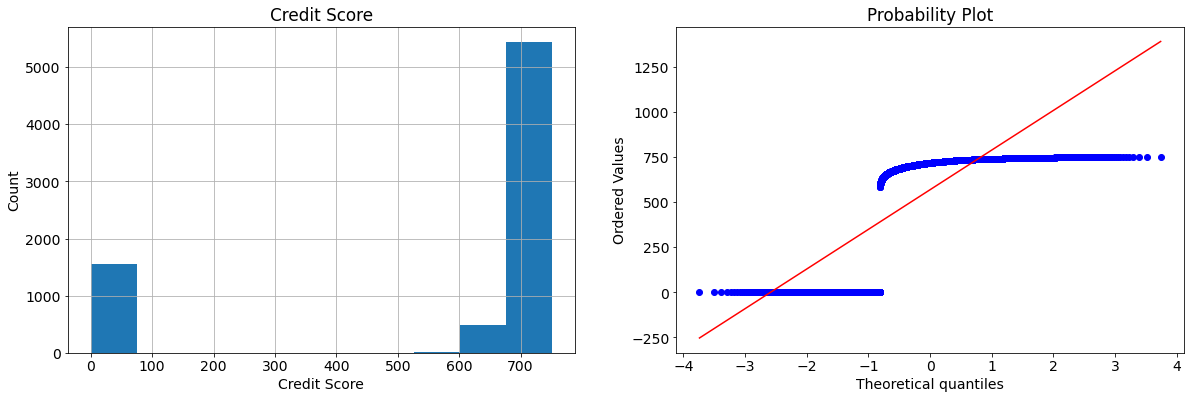

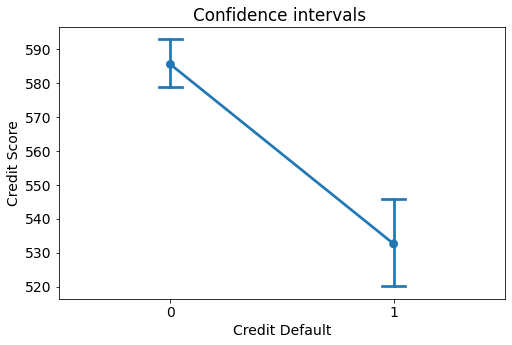

In [76]:
features_plt=[    
    'Tax Liens_group',
    'Number of Open Accounts',
    'Years of Credit History',
    'less 1 year',
    'target_encode_Home_Ownership_Annual_Income',
    'target_encode_Home_Ownership_Term le',   
    'Years in current job le',    
    'Purpose le',
    'Credit Score'
]
    
for i_features in features_plt:
    show_plt_target(df, target_name, i_features)


# CLASS

In [77]:
class DataPreprocessing:
    #"""Подготовка исходных данных"""

    def __init__(self):
        #"""Параметры класса"""
        self.medians = None
        self.quant_975 = None
        
    def fit(self, X):
        #"""Сохранение статистик"""       
        # Расчет медиан
        self.mean = X.mean()
        self.X = X.copy()
    
    @staticmethod
    # избавление от  NAN
    def passes (dtset, column_name, replacement): # датасет, столбец, на что заменить NAN
        name_new_columns_nan =column_name + ' NAN'
        dtset[name_new_columns_nan] = 0
        dtset.loc[df[column_name].isna(), name_new_columns_nan] = 1
        dtset[column_name] = dtset[column_name].fillna(replacement)
        #print (f"NAN ({column_name}) = {dtset[column_name].fillna(replacement).isna().sum()}")
        #return dtset
   
    def transform_isna(self, X):
        #"""обработка пропусков"""        
        passes(X,'Annual Income', self.mean['Annual Income'])
        passes(X,'Years in current job','< 1 year')
        passes(X,'Months since last delinquent',0)
        passes(X,'Bankruptcies',0)
        passes(X,'Term','Short Term')
        passes(X,'Credit Score',0)        
         
        #X.fillna(self.medians, inplace=True)
        
        return X

In [78]:
class FeatureGenetator():
    #"""Выбросы и генерация новых фич"""
    
    def __init__(self):
        self.X=X
        
              
    def transform(self, X):
        #target_encode_Home_Ownership_Annual_Income
        df_cat1 = X.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Annual Income']].rename(columns={
                 'Annual Income': 'target_encode_Home_Ownership_Annual_Income'
                 })
        df_cat1 = pd.DataFrame(df_cat1)
        X = X.merge(df_cat1, on='Home Ownership', how='left')        
          
        from sklearn.preprocessing import LabelEncoder 
        le1 = LabelEncoder() 
        X['Years in current job le'] = 0
        X['Years in current job le'] = le1.fit_transform(X['Years in current job'])
        
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)  
        X = pd.concat([X, pd.get_dummies(X['Years in current job'])], axis=1)
        X = X.rename(columns={'< 1 year': 'less 1 year'})        
       
        X['Years in current job_group'] = 0
        X.loc[X['Years in current job le'] == 1, 'Years in current job_group'] = 0
        X.loc[X['Years in current job le'] >= 1, 'Years in current job_group'] = 1
        
        X['Tax Liens_group'] = 0
        X.loc[X['Tax Liens'] == 0, 'Tax Liens_group'] = 0
        X.loc[X['Tax Liens'] >= 1, 'Tax Liens_group'] = 1
        
        X['Maximum Open Credit_group'] = 0
        X.loc[X['Maximum Open Credit'] <= 800000, 'Maximum Open Credit_group'] = 0
        X.loc[X['Maximum Open Credit'] > 800000, 'Maximum Open Credit_group'] = 1
        
        #X = pd.concat([X, pd.get_dummies(X['Number of Credit Problems'])], axis=1)
        #X = pd.concat([X, pd.get_dummies(X['Bankruptcies'])], axis=1)
        
        #X.loc[df['Current Loan Amount'] >= 99999999, 'Current Loan Amount'] = X['Current Loan Amount'].median()
        
        X.loc[df['Credit Score'] >= 1000, 'Credit Score'] = X['Credit Score']/10
        
        le1 = LabelEncoder()
        X['Purpose le'] = 0
        X['Purpose le'] = le1.fit_transform(X['Purpose'])
        
        le1 = LabelEncoder()
        X['Term le'] = 0
        X['Term le'] = le1.fit_transform(X['Term'])
        
        #X = pd.concat([X, pd.get_dummies(X['Term'])], axis=1)
        
        df_cat2 = X.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Term le']].rename(columns={
                            'Term le': 'target_encode_Home_Ownership_Term le'
                            })
        df_cat2 = pd.DataFrame(df_cat2)
        X = X.merge(df_cat2, on='Home Ownership', how='left')
        
        quant975(X, 'Number of Open Accounts', X['Number of Open Accounts'].quantile(.975))
        quant975(X, 'Years of Credit History', X['Years of Credit History'].quantile(.975))
        #quant975(X, 'Current Loan Amount', X['Current Loan Amount'].quantile(.975))
        
        X['target_History_CreditScore'] = X['Credit Score']/X['Years of Credit History'] #срок накопления кредитной истории        
        X['target_MD_AI'] = X['Monthly Debt']/X['Annual Income']/12 #возможность погасить ежемесячную задолженность в месяц
        
        return X, df_cat1  
    
    @staticmethod
    # удаление выбросов по квантилю 97,5
    def quant975(X, col, replacement):
        quant_975 = X[col].quantile(.95)
        X.loc[X[col] > quant_975, col] = replacement
        return quant_9

In [79]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Путь к датасетам и загрузка

In [80]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

In [82]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_trainNotNan = preprocessor.transform_isna(X_train)

X_testNotNan = preprocessor.transform_isna(X_test)
test_df_NotNan = preprocessor.transform_isna(test_df)

X_trainNotNan.shape, X_testNotNan.shape, test_df_NotNan.shape

NAN (Annual Income) = 0
NAN (Years in current job) = 0
NAN (Months since last delinquent) = 0
NAN (Bankruptcies) = 0
NAN (Term) = 0
NAN (Credit Score) = 0
NAN (Annual Income) = 0
NAN (Years in current job) = 0
NAN (Months since last delinquent) = 0
NAN (Bankruptcies) = 0
NAN (Term) = 0
NAN (Credit Score) = 0
NAN (Annual Income) = 0
NAN (Years in current job) = 0
NAN (Months since last delinquent) = 0
NAN (Bankruptcies) = 0
NAN (Term) = 0
NAN (Credit Score) = 0


((5250, 22), (2250, 22), (2500, 22))

In [83]:
features_gen = FeatureGenetator()

X_train,x1 = features_gen.transform(X_trainNotNan)
X_test,x2 = features_gen.transform(X_testNotNan)
test_df,x3 = features_gen.transform(test_df_NotNan)

X_train.shape, X_test.shape, test_df.shape

((5250, 47), (2250, 47), (2500, 47))

In [84]:
display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

In [85]:
features = X_train.select_dtypes(include=['float64', 'float32', 'float16','int64', 'uint8']).columns
#
features

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Annual Income NAN',
       'Years in current job NAN', 'Months since last delinquent NAN',
       'Bankruptcies NAN', 'Term NAN', 'Credit Score NAN',
       'target_encode_Home_Ownership_Annual_Income', 'Have Mortgage',
       'Home Mortgage', 'Own Home', 'Rent', '1 year', '10+ years', '2 years',
       '3 years', '4 years', '5 years', '6 years', '7 years', '8 years',
       '9 years', 'less 1 year', 'Years in current job_group',
       'Tax Liens_group', 'Maximum Open Credit_group',
       'target_encode_Home_Ownership_Term le', 'target_History_CreditScore',
       'target_MD_AI'],
      dtype='object')

In [86]:
features= [
       'Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 
       'Current Loan Amount', 
       'Current Credit Balance',
       'Monthly Debt', 
       'Credit Score', 
       'target_History_CreditScore',       
       'target_MD_AI',
       #'Annual Income NAN',
       #'Years in current job NAN', 'Months since last delinquent NAN',
       #'Bankruptcies NAN', 'Term NAN', 'Credit Score NAN',
        '1 year','10+ years','2 years','3 years','4 years','5 years','6 years','7 years','9 years','less 1 year',
       'target_encode_Home_Ownership_Annual_Income', 'Tax Liens_group',
       'Maximum Open Credit_group', 'target_encode_Home_Ownership_Term le' 
]

In [87]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 5249
Data columns (total 47 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Home Ownership                              5250 non-null   object 
 1   Annual Income                               5250 non-null   float64
 2   Years in current job                        5250 non-null   object 
 3   Tax Liens                                   5250 non-null   float64
 4   Number of Open Accounts                     5250 non-null   float64
 5   Years of Credit History                     5250 non-null   float64
 6   Maximum Open Credit                         5250 non-null   float64
 7   Number of Credit Problems                   5250 non-null   float64
 8   Months since last delinquent                5250 non-null   float64
 9   Bankruptcies                                5250 non-null   float64
 10  Purpose     

In [88]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 5249
Data columns (total 47 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Home Ownership                              5250 non-null   object 
 1   Annual Income                               5250 non-null   float64
 2   Years in current job                        5250 non-null   object 
 3   Tax Liens                                   5250 non-null   float64
 4   Number of Open Accounts                     5250 non-null   float64
 5   Years of Credit History                     5250 non-null   float64
 6   Maximum Open Credit                         5250 non-null   float64
 7   Number of Credit Problems                   5250 non-null   float64
 8   Months since last delinquent                5250 non-null   float64
 9   Bankruptcies                                5250 non-null   float64
 10  Purpose     

### <center>ЭКСПЕРИМЕНТЫ с моделями<a class="anchor" id="model"></a><center>

In [89]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [90]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [91]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

### Масштабрование данных

In [92]:
scaler = StandardScaler()

X_train = X_train[features].copy()
X_test = X_test[features].copy()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
#X_train_norm = pd.X_train_norm
#X_test_norm = pd.X_test_norm

### Логистическая регрессия ----------------------------------------------------

In [93]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)
model_lrCV = LogisticRegressionCV(max_iter=4, scoring='f1_macro',
                                   cv=cv, Cs=[0.001, 0.0001, 0.01, 0.1, 1])
model_lrCV.fit(X_train_norm, y_train)

evaluate_preds(model_lrCV, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3771
           1       0.98      0.19      0.31      1479

    accuracy                           0.77      5250
   macro avg       0.87      0.59      0.59      5250
weighted avg       0.82      0.77      0.71      5250

TEST

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1616
           1       0.98      0.21      0.34       634

    accuracy                           0.78      2250
   macro avg       0.87      0.60      0.60      2250
weighted avg       0.82      0.78      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1614    2
1                504  130


### k ближайших соседей -------------------------------------------------

In [94]:
model_knn = KNeighborsClassifier(n_neighbors=4)
model_knn.fit(X_train_norm, y_train)

evaluate_preds(model_knn, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      3771
           1       0.88      0.36      0.51      1479

    accuracy                           0.81      5250
   macro avg       0.84      0.67      0.70      5250
weighted avg       0.82      0.81      0.78      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1616
           1       0.65      0.28      0.39       634

    accuracy                           0.76      2250
   macro avg       0.71      0.61      0.62      2250
weighted avg       0.74      0.76      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1523   93
1                458  176


In [95]:
disbalance = int(y_train.value_counts()[0]) / int(y_train.value_counts()[1])
disbalance

2.5496957403651117

### Support Vector Machine ---------------------------------------------------------------

In [96]:
model_lr = LogisticRegression()
model_lr.fit(X_train_norm, y_train)

evaluate_preds(model_lr, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3771
           1       0.98      0.19      0.31      1479

    accuracy                           0.77      5250
   macro avg       0.87      0.59      0.59      5250
weighted avg       0.82      0.77      0.71      5250

TEST

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1616
           1       0.96      0.21      0.34       634

    accuracy                           0.77      2250
   macro avg       0.86      0.60      0.60      2250
weighted avg       0.82      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1611    5
1                504  130


In [97]:
%%time
model_svc = SVC(C=0.05,
                kernel='rbf'
                )
model_svc.fit(X_train, y_train)

evaluate_preds(model_svc, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3771
           1       0.00      0.00      0.00      1479

    accuracy                           0.72      5250
   macro avg       0.36      0.50      0.42      5250
weighted avg       0.52      0.72      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1616
           1       0.00      0.00      0.00       634

    accuracy                           0.72      2250
   macro avg       0.36      0.50      0.42      2250
weighted avg       0.52      0.72      0.60      2250

CONFUSION MATRIX

col_0              0
Credit Default      
0               1616
1                634
Wall time: 4.92 s


### Дерево решений ---------------------------------------------------------------------

In [98]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    criterion='gini',
#                                   class_weight={0:1, 1:disbalance},
                                    min_impurity_decrease=5,
                                    min_samples_split=10,
                                    min_samples_leaf=10,
                                    max_depth=2
                                    )
model_tree

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=5,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=21)

In [99]:
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3771
           1       0.00      0.00      0.00      1479

    accuracy                           0.72      5250
   macro avg       0.36      0.50      0.42      5250
weighted avg       0.52      0.72      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1616
           1       0.00      0.00      0.00       634

    accuracy                           0.72      2250
   macro avg       0.36      0.50      0.42      2250
weighted avg       0.52      0.72      0.60      2250

CONFUSION MATRIX

col_0              0
Credit Default      
0               1616
1                634


In [100]:
model_tree.score(X_test,y_test)

0.7182222222222222

### Случайный лес -----------------------------------------------------

In [101]:
%%time
model_rfc = RandomForestClassifier(random_state=21,
                                    criterion='gini',
#                                    class_weight={0:1, 1:3.6},
                                    min_impurity_decrease=5,
                                    min_samples_split=10,
                                    min_samples_leaf=10,
                                    max_depth=2
                                   
                            )
model_rfc.fit(X_train, y_train)

evaluate_preds(model_rfc, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3771
           1       0.00      0.00      0.00      1479

    accuracy                           0.72      5250
   macro avg       0.36      0.50      0.42      5250
weighted avg       0.52      0.72      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1616
           1       0.00      0.00      0.00       634

    accuracy                           0.72      2250
   macro avg       0.36      0.50      0.42      2250
weighted avg       0.52      0.72      0.60      2250

CONFUSION MATRIX

col_0              0
Credit Default      
0               1616
1                634
Wall time: 406 ms


### XGBoost --------------------------------------------------------------------------------------------------

In [102]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21, 
                              n_estimators=100,
                              learning_rate=0.1,
                              max_depth=5,
                              eval_metric='error'                              
                            )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      3771
           1       0.95      0.38      0.55      1479

    accuracy                           0.82      5250
   macro avg       0.88      0.69      0.72      5250
weighted avg       0.85      0.82      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1616
           1       0.76      0.29      0.42       634

    accuracy                           0.77      2250
   macro avg       0.77      0.63      0.64      2250
weighted avg       0.77      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1557   59
1                450  184
Wall time: 695 ms


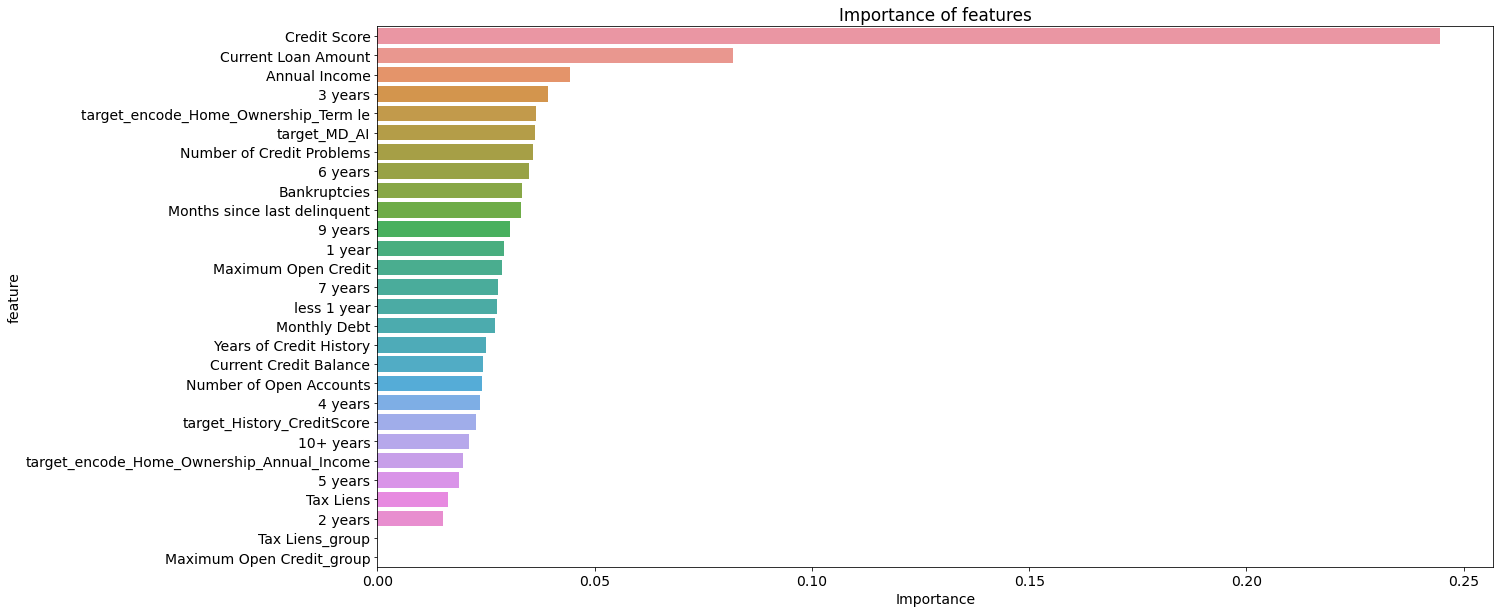

In [103]:
#Важность признаков
important_features_top = show_feature_importances(X_train.columns,
                                                  model_xgb.feature_importances_, get_top=19)

### XGBoost / GridSearchCV

In [104]:
# Parameter Tuning
model_xgb_GS = xgb.XGBClassifier()
param_dist = {"max_depth": [5,10,20],
              #"min_child_weight" : [1,3,6],
              "n_estimators": [100, 150, 200],
              "learning_rate": [0.05, 0.1,0.16],
              "eval_metric": ['error'],
              }
grid_search = GridSearchCV(model_xgb_GS, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)


In [105]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [106]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [107]:
model_xgb_GS = xgb.XGBClassifier(random_state=21, 
                              max_depth=5, 
                              learning_rate=0.05,
                              n_estimators=100,
                              reg_lambda=1, eval_metric='error')

In [108]:
model_xgb_GS.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=21, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [109]:
evaluate_preds(model_xgb_GS, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3771
           1       0.96      0.26      0.41      1479

    accuracy                           0.79      5250
   macro avg       0.86      0.63      0.64      5250
weighted avg       0.83      0.79      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1616
           1       0.89      0.24      0.38       634

    accuracy                           0.78      2250
   macro avg       0.83      0.62      0.62      2250
weighted avg       0.80      0.78      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1597   19
1                479  155


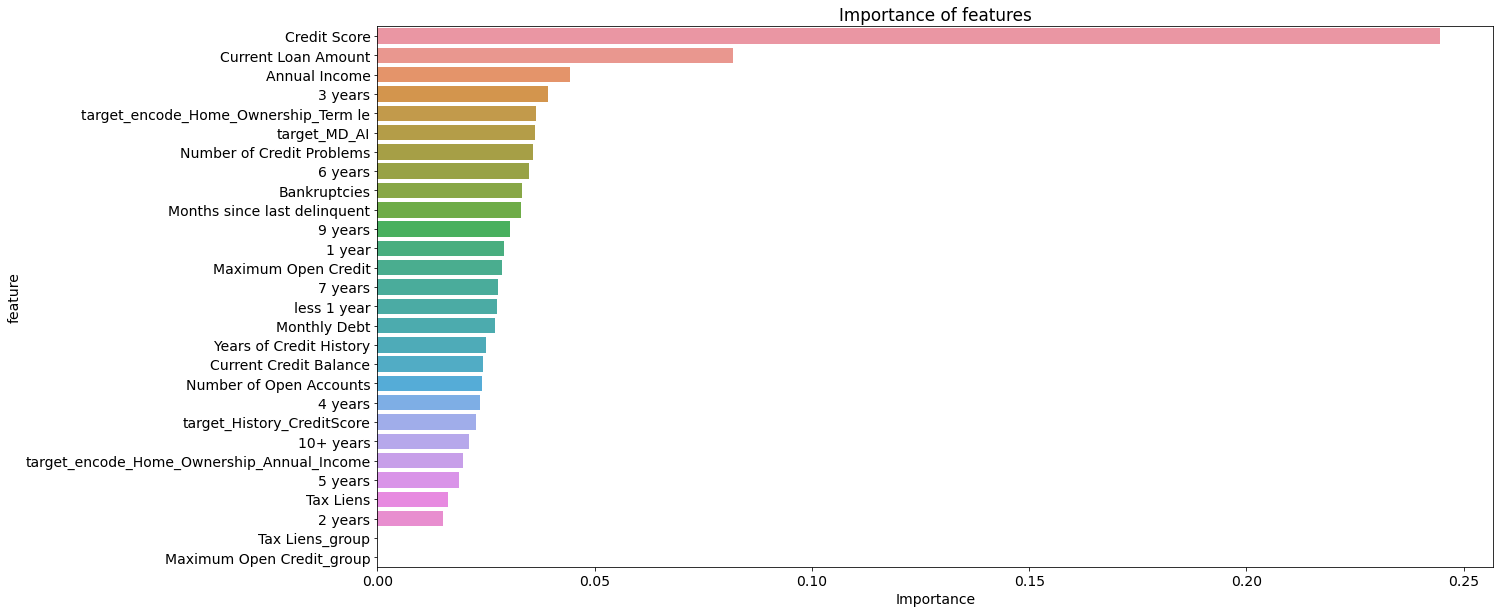

In [110]:
#Важность признаков
important_features_top = show_feature_importances(X_train.columns,
                                                  model_xgb.feature_importances_, get_top=19)

### XGBoost / KFold

In [111]:
from sklearn.model_selection import RepeatedStratifiedKFold
model = xgb.XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
score

array([0.74857143, 0.74190476, 0.74      , 0.75238095, 0.75714286,
       0.75333333, 0.76857143, 0.73809524, 0.76095238, 0.73428571,
       0.74      , 0.75047619, 0.7447619 , 0.74666667, 0.75809524,
       0.73714286, 0.74      , 0.74952381, 0.76571429, 0.76380952,
       0.74      , 0.76095238, 0.76571429, 0.74952381, 0.75047619])

In [112]:
print((np.mean(score) * 100).round(3))

75.032


### LightGBM -----------------------------------------------------------------------------------------------------------------------------

In [113]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:disbalance},
                                 num_leaves=3,
                                 #min_data_in_leaf=200,
                                 #min_child_samples=20,
                                 n_estimators=100,
                                 scoring='f1'
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Unknown parameter: scoring
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      3771
           1       0.46      0.71      0.56      1479

    accuracy                           0.68      5250
   macro avg       0.66      0.69      0.65      5250
weighted avg       0.74      0.68      0.70      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.65      0.74      1616
           1       0.44      0.70      0.54       634

    accuracy                           0.67      2250
   macro avg       0.64      0.68      0.64      2250
weighted avg       0.73      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1057  559
1                191  443
Wall time: 151 ms


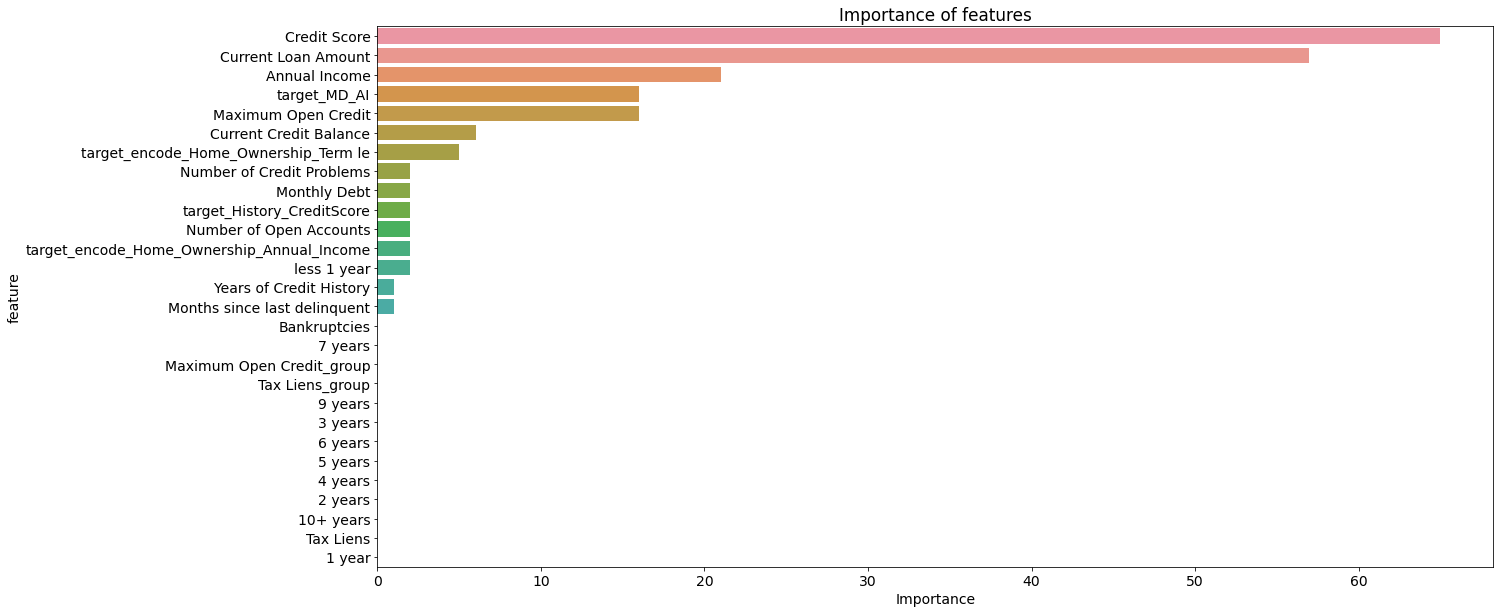

In [114]:
#Важность признаков
important_features_top = show_feature_importances(X_train.columns,
                                                  model_lgbm.feature_importances_, get_top=19)

In [115]:
# уменьшение колва признаков
features_new=['Annual Income',
 #'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 #'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 #'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'target_History_CreditScore',
 'target_MD_AI',
 #'1 year', #'10+ years', #'2 years', #'3 years', #'4 years', #'5 years', #'6 years', #'7 years', #'9 years', 'less 1 year',
 'target_encode_Home_Ownership_Annual_Income',
 #'Tax Liens_group',
 'Maximum Open Credit_group',
 'target_encode_Home_Ownership_Term le']

In [116]:
model_lgbm_new = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:disbalance},
                                 num_leaves=4,
                                 #min_data_in_leaf=200,
                                 min_child_samples=20,
                                 n_estimators=100,
                                #scoring='f1'
                                )
model_lgbm_new.fit(X_train[features_new], y_train)

evaluate_preds(model_lgbm_new, X_train[features_new], X_test[features_new], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      3771
           1       0.48      0.73      0.58      1479

    accuracy                           0.70      5250
   macro avg       0.67      0.71      0.67      5250
weighted avg       0.76      0.70      0.71      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      1616
           1       0.44      0.69      0.53       634

    accuracy                           0.66      2250
   macro avg       0.64      0.67      0.63      2250
weighted avg       0.73      0.66      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1051  565
1                198  436


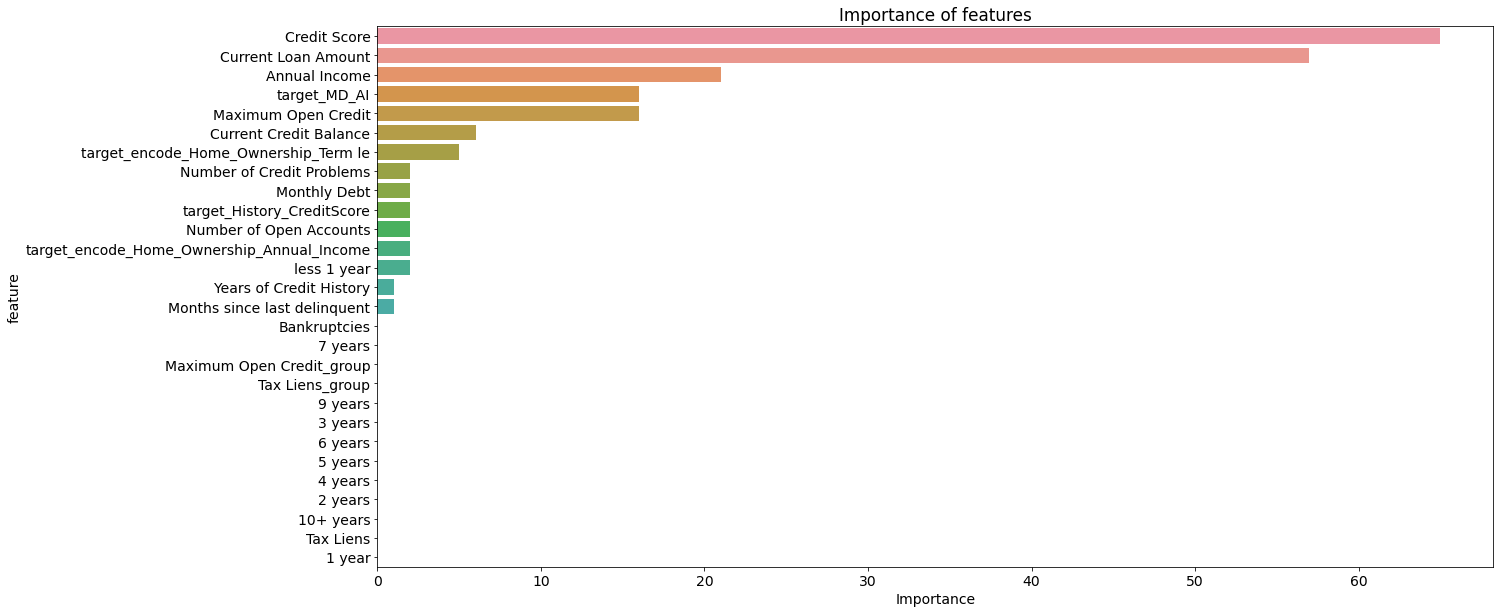

In [117]:
#Важность признаков
important_features_top = show_feature_importances(X_train.columns,
                                                  model_lgbm.feature_importances_, get_top=19)

#### LightGBM / GridSearchCV 

In [118]:
model_lgbm_GS = lgbm.LGBMClassifier(random_state=21,silent=True)
param_dist = {"max_depth": [5,10, 15],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [3,5,7,10],
              "n_estimators": [100, 150, 200, 300],
              "class_weight": [{0:1, 1:disbalance}],          
              
             }
grid_search = GridSearchCV(model_lgbm_GS, n_jobs=-1, param_grid=param_dist, cv = 3)

In [119]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=21), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 2.5496957403651117}],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 150, 200, 300],
                         'num_leaves': [3, 5, 7, 10]})

In [120]:
grid_search.best_estimator_

LGBMClassifier(class_weight={0: 1, 1: 2.5496957403651117}, max_depth=5,
               n_estimators=300, num_leaves=10, random_state=21)

In [121]:
model_lgbm_GS = lgbm.LGBMClassifier(learning_rate=0.01, max_depth=5, 
                         num_leaves=10,
                         n_estimators=300,
                         random_state=21,class_weight={0:1, 1:disbalance},scoring='f1')

In [122]:
model_lgbm_GS.fit(X_train,y_train)

LGBMClassifier(class_weight={0: 1, 1: 2.5496957403651117}, learning_rate=0.01,
               max_depth=5, n_estimators=300, num_leaves=10, random_state=21,
               scoring='f1')

In [123]:
evaluate_preds(model_lgbm_GS, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      3771
           1       0.49      0.74      0.59      1479

    accuracy                           0.71      5250
   macro avg       0.68      0.72      0.68      5250
weighted avg       0.76      0.71      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1616
           1       0.46      0.68      0.54       634

    accuracy                           0.68      2250
   macro avg       0.65      0.68      0.65      2250
weighted avg       0.73      0.68      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1104  512
1                206  428


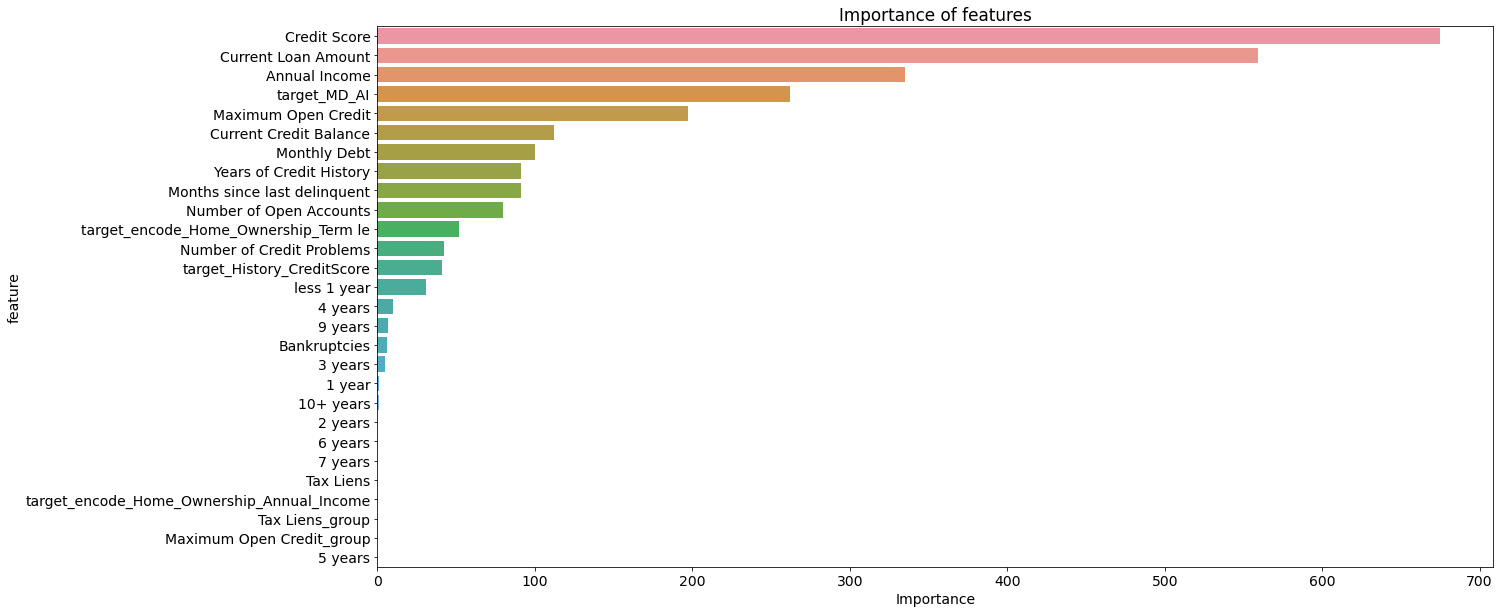

In [124]:
#Важность признаков
important_features_top = show_feature_importances(X_train.columns,
                                                  model_lgbm_GS.feature_importances_, get_top=19)

### CatBoost ----------------------------------------------------------------------------------------------

In [125]:
frozen_params = {
    'silent':True, 
    "random_state":21,
    #  cat_features=CAT_FEATURE_NAMES,
    'class_weights':[1, disbalance],
    'allow_writing_files':False,
    'learning_rate':0.2,        
    'eval_metric':'F1',
    'early_stopping_rounds':30,
    'custom_metric':['Precision', 'Recall'],
    'subsample':0.8,
}

In [126]:
%%time
model_catb = catb.CatBoostClassifier(**frozen_params, 
                                     iterations=300, 
                                     max_depth=3,
                                     #n_estimators=95,
                                     reg_lambda=0.6,
                                    )

model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.71      0.78      3771
           1       0.50      0.72      0.59      1479

    accuracy                           0.72      5250
   macro avg       0.68      0.72      0.69      5250
weighted avg       0.76      0.72      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.69      0.76      1616
           1       0.46      0.68      0.55       634

    accuracy                           0.69      2250
   macro avg       0.65      0.68      0.66      2250
weighted avg       0.74      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1120  496
1                206  428
Wall time: 720 ms


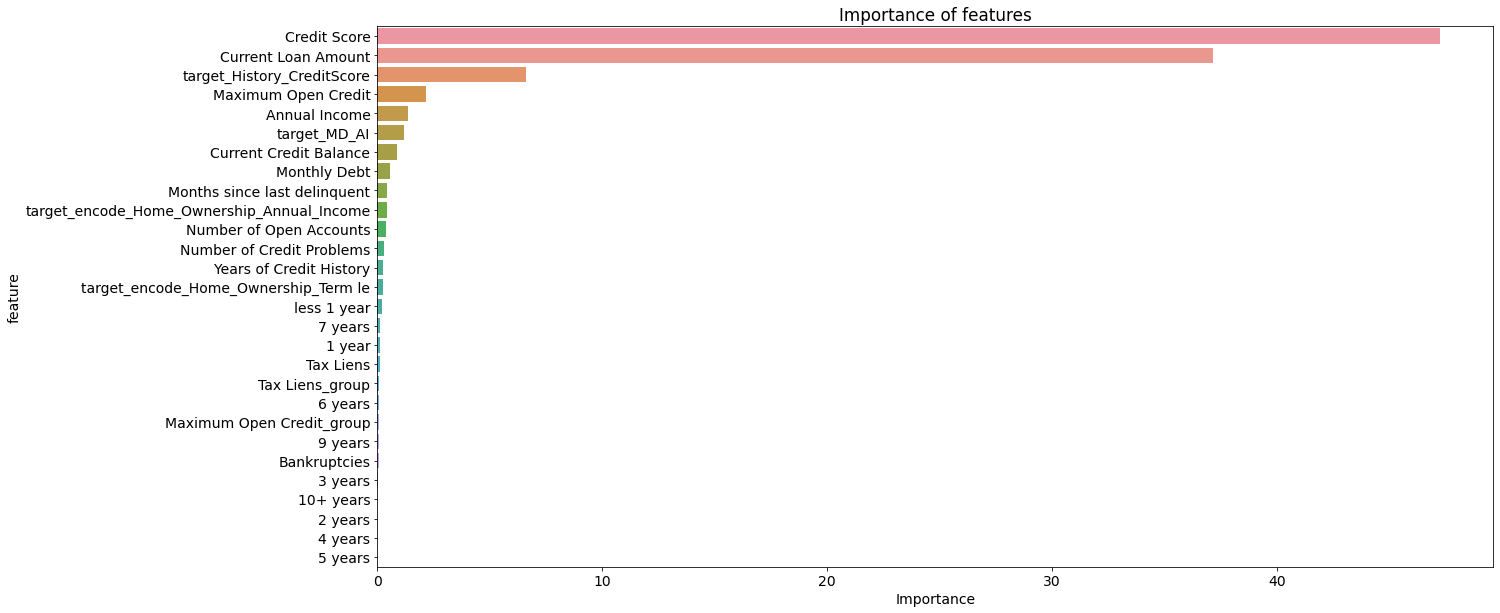

In [127]:
#Важность признаков
important_features_top = show_feature_importances(X_train.columns,
                                                  model_catb.feature_importances_, get_top=19)

### CatBoost / KFold ----------------------------------------------------------------------------------------------

In [128]:
params = {
    'reg_lambda': np.linspace(0.6, 4, 20)
}

In [129]:
model_catb_KFold = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=3)

In [130]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [131]:
grid_search = model_catb_KFold.randomized_search(params, X_train, y_train, n_iter=20, 
                                                 cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6766125729
bestIteration = 2

0:	loss: 0.6766126	best: 0.6766126 (0)	total: 189ms	remaining: 3.59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6766125729
bestIteration = 2

1:	loss: 0.6766126	best: 0.6766126 (0)	total: 338ms	remaining: 3.04s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6766125729
bestIteration = 2

2:	loss: 0.6766126	best: 0.6766126 (0)	total: 492ms	remaining: 2.79s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6766125729
bestIteration = 2

3:	loss: 0.6766126	best: 0.6766126 (0)	total: 622ms	remaining: 2.49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6673095849
bestIteration = 3

4:	loss: 0.6673096	best: 0.6766126 (0)	total: 778ms	remaining: 2.33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6766125729
bestIteration = 2

5:	loss: 0.6766126	best: 0.6766126 (0)	total: 923ms	remaining: 2.15

In [132]:
grid_search

{'params': {'l2_leaf_reg': 0.6},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,

In [133]:
%%time

evaluate_preds(model_catb_KFold, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      3771
           1       0.66      0.86      0.75      1479

    accuracy                           0.84      5250
   macro avg       0.80      0.84      0.81      5250
weighted avg       0.86      0.84      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1616
           1       0.48      0.61      0.54       634

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1203  413
1                247  387
Wall time: 49.1 ms


### <center>Финальный результат<a class="anchor" id="rezult"></a><center>

Прогнозирование на тестовом датасете

In [134]:
test_df.shape

(2500, 47)

In [135]:
test_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,9 years,less 1 year,Years in current job_group,Tax Liens_group,Maximum Open Credit_group,Purpose le,Term le,target_encode_Home_Ownership_Term le,target_History_CreditScore,target_MD_AI
0,Rent,1.369512e+06,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,0,0,1,0,0,3,1,0.834314,0.000000,0.000415
1,Rent,2.318380e+05,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,...,0,0,0,0,0,4,1,0.834314,21.376147,0.000833
2,Home Mortgage,1.152540e+06,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,...,0,0,1,0,0,3,1,0.664490,529.927007,0.001354
3,Home Mortgage,1.220313e+06,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,0,0,1,0,0,3,1,0.664490,43.470588,0.001882
4,Home Mortgage,2.340952e+06,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,...,0,0,1,0,1,3,0,0.664490,29.915254,0.001517


In [136]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 47 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Home Ownership                              2500 non-null   object 
 1   Annual Income                               2500 non-null   float64
 2   Years in current job                        2500 non-null   object 
 3   Tax Liens                                   2500 non-null   float64
 4   Number of Open Accounts                     2500 non-null   float64
 5   Years of Credit History                     2500 non-null   float64
 6   Maximum Open Credit                         2500 non-null   float64
 7   Number of Credit Problems                   2500 non-null   float64
 8   Months since last delinquent                2500 non-null   float64
 9   Bankruptcies                                2500 non-null   float64
 10  Purpose     

In [137]:
f1_score(y_test, model_catb.predict(X_test[features]))

0.5494223363286266

In [138]:
f1_score(y_test, model_catb_KFold.predict(X_test[features]))

0.5397489539748955

In [139]:
f1_score(y_test, model_lgbm.predict(X_test[features]))

0.541564792176039

In [140]:
f1_score(y_test, model_lgbm_GS.predict(X_test[features]))

0.5438373570520967

In [141]:
f1_score(y_test, model_xgb.predict(X_test[features]))

0.41961231470923605

In [142]:
f1_score(y_test, model_xgb_GS.predict(X_test[features]))

0.38366336633663367

In [143]:
final_model= model_catb #model_lgbm 60409 #model_catb 61041 на Kaggle

In [144]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
11,Credit Score,47.258853
8,Current Loan Amount,37.149047
12,target_History_CreditScore,6.611748
4,Maximum Open Credit,2.151825
0,Annual Income,1.339410
13,target_MD_AI,1.187598
9,Current Credit Balance,0.880916
10,Monthly Debt,0.555362
6,Months since last delinquent,0.430797
24,target_encode_Home_Ownership_Annual_Income,0.406934


In [145]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [146]:
predictions = final_model.predict(test_df[features])
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [147]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0


In [148]:
submit.to_csv('final_model_submit.csv', index=False)

### <center>Сохранение модели<a class="anchor" id="savemodel"></a><center>

In [149]:
MODEL_FILE_PATH = './model.pkl'

In [150]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb, file)

In [151]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

In [152]:
import sklearn
print(sklearn.__version__)

0.24.2


In [153]:
pip freeze

-cikit-learn @ file:///C:/ci/scikit-learn_1592853510272/work
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
argh==0.26.2
asn1crypto==1.3.0
astroid @ file:///C:/ci/astroid_1592487315634/work
astropy==4.0.1.post1
atomicwrites==1.4.0
attrs==19.3.0
autopep8 @ file:///tmp/build/80754af9/autopep8_1592412889138/work
Babel==2.8.0
backcall==0.2.0
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1618170165463/work
backports.shutil-get-terminal-size==1.0.0
backports.tempfile @ file:///home/linux1/recipes/ci/backports.tempfile_1610991236607/work
backports.weakref==1.0.post1
bcrypt==3.1.7
beautifulsoup4==4.9.1
bitarray @ file:///C:/ci/bitarray_1594751093906/work
bkcharts==0.2
bleach==3.1.5
bokeh @ file:///C:/ci/bokeh_1593178781838/work
boto==2.49.0
Bottleneck==1.3.2
brotlipy==0.7.0
catboost @ https://pypi.org/packages/cp38/c/catboost/catboost-0.26.1-cp38-none-win_amd64.whl
certifi==2020.6.20
cffi==1.14.0
chardet==3